In [1]:
import numpy as np
import pandas as pd
import datetime
import math
from collections import defaultdict
import itertools
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV, ElasticNet
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error,make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.compose import make_column_selector as selector

In [5]:
from warnings import simplefilter
simplefilter("ignore")

pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format

# **Import Data**

In [6]:
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
holidays_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
submission_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
submission_data.rename(columns = {'id':'id', 'sales':'submission_d'}, inplace = True )
stores_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [7]:
train_data.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE   0.00            0
1   1  2013-01-01          1   BABY CARE   0.00            0
2   2  2013-01-01          1      BEAUTY   0.00            0
3   3  2013-01-01          1   BEVERAGES   0.00            0
4   4  2013-01-01          1       BOOKS   0.00            0

In [8]:
test_data.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [9]:
oil_data.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [10]:
holidays_data['date'] = pd.to_datetime(holidays_data['date'], format = "%Y-%m-%d")
holidays_data.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [11]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [12]:
oil_data['date'] = pd.to_datetime(oil_data['date'], format = "%Y-%m-%d")
transactions_data['date'] = pd.to_datetime(transactions_data['date'], format = "%Y-%m-%d")
train_data['date'] = pd.to_datetime(train_data['date'], format = "%Y-%m-%d")
test_data['date'] = pd.to_datetime(test_data['date'], format = "%Y-%m-%d")

# **Pre Processing**

3.1 Missing dates in data

Here we can see train_data:

In [13]:
train_data.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [15]:
train_data_start = train_data.date.min().date()
train_data_end = train_data.date.max().date()

In [16]:
missing_dates = pd.date_range(train_data_start, train_data_end
                             ).difference(train_data.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

missing_dates

['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

It is very important that there are no gaps in the dates, so let's assume that the stores were closed on this day and therefore fill the data with zeros.

In [17]:
multi_idx = pd.MultiIndex.from_product([pd.date_range(train_data_start, train_data_end), 
                                        train_data.store_nbr.unique(), 
                                        train_data.family.unique()],
                                        names=["date", "store_nbr", "family"],)

In [18]:
multi_idx

MultiIndex([('2013-01-01', 1,                 'AUTOMOTIVE'),
            ('2013-01-01', 1,                  'BABY CARE'),
            ('2013-01-01', 1,                     'BEAUTY'),
            ('2013-01-01', 1,                  'BEVERAGES'),
            ('2013-01-01', 1,                      'BOOKS'),
            ('2013-01-01', 1,               'BREAD/BAKERY'),
            ('2013-01-01', 1,                'CELEBRATION'),
            ('2013-01-01', 1,                   'CLEANING'),
            ('2013-01-01', 1,                      'DAIRY'),
            ('2013-01-01', 1,                       'DELI'),
            ...
            ('2017-08-15', 9,                  'MAGAZINES'),
            ('2017-08-15', 9,                      'MEATS'),
            ('2017-08-15', 9,              'PERSONAL CARE'),
            ('2017-08-15', 9,               'PET SUPPLIES'),
            ('2017-08-15', 9,    'PLAYERS AND ELECTRONICS'),
            ('2017-08-15', 9,                    'POULTRY'),
        

In [19]:
train_data = train_data.set_index(["date", "store_nbr", "family"]
                                 ).reindex(multi_idx).reset_index()
# fill missing values with 0s
train_data[["sales", "onpromotion"]] = train_data[["sales", "onpromotion"]].fillna(0.)
# interpolate  for the 'id'
train_data.id = train_data.id.interpolate(method="linear")

train_data

date  store_nbr                      family         id   sales  \
0       2013-01-01          1                  AUTOMOTIVE       0.00    0.00   
1       2013-01-01          1                   BABY CARE       1.00    0.00   
2       2013-01-01          1                      BEAUTY       2.00    0.00   
3       2013-01-01          1                   BEVERAGES       3.00    0.00   
4       2013-01-01          1                       BOOKS       4.00    0.00   
...            ...        ...                         ...        ...     ...   
3008011 2017-08-15          9                     POULTRY 3000883.00  438.13   
3008012 2017-08-15          9              PREPARED FOODS 3000884.00  154.55   
3008013 2017-08-15          9                     PRODUCE 3000885.00 2419.73   
3008014 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES 3000886.00  121.00   
3008015 2017-08-15          9                     SEAFOOD 3000887.00   16.00   

         onpromotion  
0               0.00  
1               0.00  
2               0.00  
3               0.00  
4               0.00  
...              ...  
3008011         0.00  
3008012         1.00  
3008013       148.00  
3008014         8.00  
3008015         0.00  

[3008016 rows x 6 columns]

In [20]:
train_data.tail(416000)

date  store_nbr                      family         id   sales  \
2592016 2016-12-25         36  SCHOOL AND OFFICE SUPPLIES 2585681.55    0.00   
2592017 2016-12-25         36                     SEAFOOD 2585681.56    0.00   
2592018 2016-12-25         37                  AUTOMOTIVE 2585681.56    0.00   
2592019 2016-12-25         37                   BABY CARE 2585681.56    0.00   
2592020 2016-12-25         37                      BEAUTY 2585681.56    0.00   
...            ...        ...                         ...        ...     ...   
3008011 2017-08-15          9                     POULTRY 3000883.00  438.13   
3008012 2017-08-15          9              PREPARED FOODS 3000884.00  154.55   
3008013 2017-08-15          9                     PRODUCE 3000885.00 2419.73   
3008014 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES 3000886.00  121.00   
3008015 2017-08-15          9                     SEAFOOD 3000887.00   16.00   

         onpromotion  
2592016         0.00  
2592017         0.00  
2592018         0.00  
2592019         0.00  
2592020         0.00  
...              ...  
3008011         0.00  
3008012         1.00  
3008013       148.00  
3008014         8.00  
3008015         0.00  

[416000 rows x 6 columns]

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   id           float64       
 4   sales        float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 137.7+ MB


Here we can see test_data

In [22]:
test_data.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [23]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [24]:
test_data_start = test_data.date.min().date()
test_data_end = test_data.date.max().date()

missing_dates_test = pd.date_range(test_data_start, test_data_end
                             ).difference(test_data.date.unique())
missing_dates_test = missing_dates_test.strftime("%Y-%m-%d").tolist()

missing_dates_test

[]

How we can notice there are no gaps in the test data.

In [25]:
test_data['test'] = 1
train_data['test'] = 0

In [26]:
test_data.head()

id       date  store_nbr      family  onpromotion  test
0  3000888 2017-08-16          1  AUTOMOTIVE            0     1
1  3000889 2017-08-16          1   BABY CARE            0     1
2  3000890 2017-08-16          1      BEAUTY            2     1
3  3000891 2017-08-16          1   BEVERAGES           20     1
4  3000892 2017-08-16          1       BOOKS            0     1

In [27]:
train_data.head()

date  store_nbr      family   id  sales  onpromotion  test
0 2013-01-01          1  AUTOMOTIVE 0.00   0.00         0.00     0
1 2013-01-01          1   BABY CARE 1.00   0.00         0.00     0
2 2013-01-01          1      BEAUTY 2.00   0.00         0.00     0
3 2013-01-01          1   BEVERAGES 3.00   0.00         0.00     0
4 2013-01-01          1       BOOKS 4.00   0.00         0.00     0

In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   test         28512 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.3+ MB


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   id           float64       
 4   sales        float64       
 5   onpromotion  float64       
 6   test         int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 160.6+ MB


In [30]:
oil_data.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [31]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


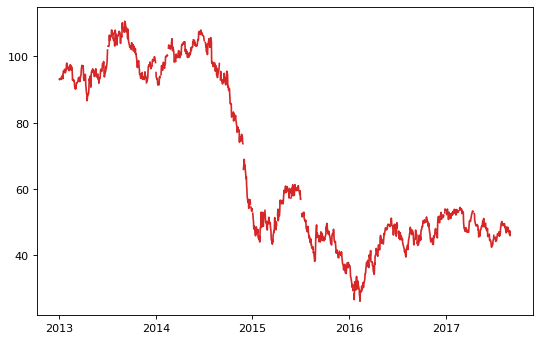

In [32]:
plt.figure(figsize=(8,5), dpi= 80)
plt.plot('date', 'dcoilwtico', data=oil_data, color='tab:red')
plt.show()

As we can see, oil prices are not known on all days, therefore we will use interpolation to fill in the gaps

In [33]:
oil_data = oil_data.merge(pd.DataFrame({"date": pd.date_range(train_data_start, 
                                                              test_data_end)}),
                          on="date",how="outer",).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil_data.dcoilwtico = oil_data.dcoilwtico.interpolate(method="linear", limit_direction="both")

In [34]:
oil_data.head(100)

date  dcoilwtico
0  2013-01-01       93.14
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-05       93.15
..        ...         ...
95 2013-04-06       92.96
96 2013-04-07       93.16
97 2013-04-08       93.36
98 2013-04-09       94.18
99 2013-04-10       94.59

[100 rows x 2 columns]

In [35]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


**Transactions**

In [36]:
transactions_data.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

Fill in the missing values ​​for transactions using interpolation, except for days with zero sales

In [37]:
num_store = train_data.store_nbr.nunique()
train_len = (train_data_end - train_data_start).days + 1

In [38]:
num_store

54

In [39]:
train_len

1688

In [40]:
num_zero_sales = (train_data.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transactions_data.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [41]:
num_zero_sales

7546

In [42]:
total_rec

91152

In [43]:
curr_rec

83488

In [44]:
missing_rec

118

In [45]:
store_sales = train_data.groupby(["date", "store_nbr"]).sales.sum().reset_index()

In [46]:
store_sales

date  store_nbr    sales
0     2013-01-01          1     0.00
1     2013-01-01          2     0.00
2     2013-01-01          3     0.00
3     2013-01-01          4     0.00
4     2013-01-01          5     0.00
...          ...        ...      ...
91147 2017-08-15         50 16879.12
91148 2017-08-15         51 20154.56
91149 2017-08-15         52 18600.05
91150 2017-08-15         53  8208.19
91151 2017-08-15         54 12666.86

[91152 rows x 3 columns]

In [47]:
transactions_data = transactions_data.merge(
    store_sales, on=["date", "store_nbr"],how="outer").sort_values(
    ["date", "store_nbr"],ignore_index=True)

In [48]:
transactions_data

date  store_nbr  transactions    sales
0     2013-01-01          1           NaN     0.00
1     2013-01-01          2           NaN     0.00
2     2013-01-01          3           NaN     0.00
3     2013-01-01          4           NaN     0.00
4     2013-01-01          5           NaN     0.00
...          ...        ...           ...      ...
91147 2017-08-15         50       2804.00 16879.12
91148 2017-08-15         51       1573.00 20154.56
91149 2017-08-15         52       2255.00 18600.05
91150 2017-08-15         53        932.00  8208.19
91151 2017-08-15         54        802.00 12666.86

[91152 rows x 4 columns]

In [49]:
# fill missing values with 0s for days with zero sales
transactions_data.loc[transactions_data.sales.eq(0), "transactions"] = 0
transactions_data = transactions_data.drop(columns=["sales"])

In [50]:
transactions_data

date  store_nbr  transactions
0     2013-01-01          1          0.00
1     2013-01-01          2          0.00
2     2013-01-01          3          0.00
3     2013-01-01          4          0.00
4     2013-01-01          5          0.00
...          ...        ...           ...
91147 2017-08-15         50       2804.00
91148 2017-08-15         51       1573.00
91149 2017-08-15         52       2255.00
91150 2017-08-15         53        932.00
91151 2017-08-15         54        802.00

[91152 rows x 3 columns]

In [51]:
# fill remaining missing values using linear interpolation
transactions_data.transactions = transactions_data.groupby(
    "store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both"))

In [52]:
transactions_data

date  store_nbr  transactions
0     2013-01-01          1          0.00
1     2013-01-01          2          0.00
2     2013-01-01          3          0.00
3     2013-01-01          4          0.00
4     2013-01-01          5          0.00
...          ...        ...           ...
91147 2017-08-15         50       2804.00
91148 2017-08-15         51       1573.00
91149 2017-08-15         52       2255.00
91150 2017-08-15         53        932.00
91151 2017-08-15         54        802.00

[91152 rows x 3 columns]

In [53]:
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91152 entries, 0 to 91151
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          91152 non-null  datetime64[ns]
 1   store_nbr     91152 non-null  int64         
 2   transactions  91152 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


**Holidays and impacts on sales**

In [54]:
holidays_data.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

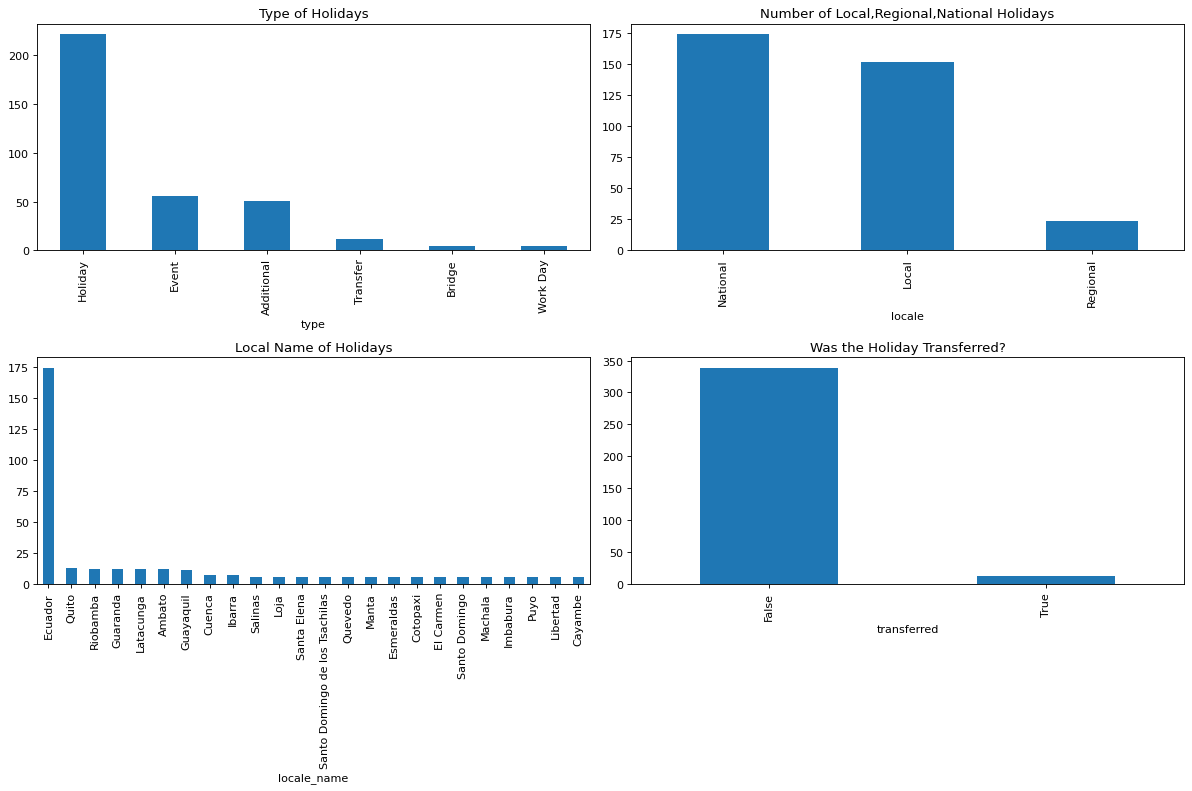

In [55]:
plt.figure(figsize=(15, 10), dpi= 80)
plt.subplot (2, 2, 1)
holidays_type = holidays_data['type'].value_counts().plot.bar().set_title('Type of Holidays')
plt.subplot (2, 2, 2)
holidays_locale = holidays_data['locale'].value_counts().plot.bar().set_title('Number of Local,Regional,National Holidays')
plt.subplot (2, 2, 3)
holidays_locale_name = holidays_data['locale_name'].value_counts().plot.bar().set_title('Local Name of Holidays')
plt.subplot (2, 2, 4)
holidays_transferred = holidays_data['transferred'].value_counts().plot.bar().set_title('Was the Holiday Transferred?')
plt. tight_layout ()
plt.show()

In [56]:
print('Holidays types:', holidays_data['type'].unique())
print('Holidays region types:', holidays_data['locale'].unique()) 
print('Holidays locale names:', holidays_data['locale_name'].unique())  

national_locale_name = sorted(holidays_data[holidays_data['locale']=="National"
                                           ]['locale_name'].unique().tolist())
regional_locale_name = sorted(holidays_data[holidays_data['locale']=="Regional"
                                           ]['locale_name'].unique().tolist())
local_locale_name = sorted(holidays_data[holidays_data['locale']=="Local"
                                        ]['locale_name'].unique().tolist())

print(f'Locale names for national holidays:{national_locale_name}')
print(f'Locale names for regional holidays:{regional_locale_name}')
print(f'Locale names for local holidays:{local_locale_name}')

Holidays types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Holidays region types: ['Local' 'Regional' 'National']
Holidays locale names: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
Locale names for national holidays:['Ecuador']
Locale names for regional holidays:['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']
Locale names for local holidays:['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [57]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores_data['city'].str.lower()) | set(stores_data['state'].str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

holidays_data['description'] = holidays_data.apply(
    lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""), 
    axis=1,).apply(process_holiday).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,).replace(
    r"\s+|-", " ", regex=True,).str.strip()


In [58]:
# remove transferred holidays
holidays_data = holidays_data[holidays_data['transferred'].eq(False)]

#Saturdays designated as work days 
work_days = holidays_data[holidays_data['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}
                                              ).reset_index(drop=True)
work_days['work_day'] = work_days['work_day'].notna().astype(int)


In [59]:
# remove work days after extracting above
holidays_data = holidays_data[holidays_data['type']!="Work Day"].reset_index(drop=True)
holidays_data

date        type    locale locale_name        description  \
0   2012-03-02     Holiday     Local       Manta          fundacion   
1   2012-04-01     Holiday  Regional    Cotopaxi  provincializacion   
2   2012-04-12     Holiday     Local      Cuenca          fundacion   
3   2012-04-14     Holiday     Local    Libertad      cantonizacion   
4   2012-04-21     Holiday     Local    Riobamba      cantonizacion   
..         ...         ...       ...         ...                ...   
328 2017-12-22  Additional  National     Ecuador            navidad   
329 2017-12-23  Additional  National     Ecuador            navidad   
330 2017-12-24  Additional  National     Ecuador            navidad   
331 2017-12-25     Holiday  National     Ecuador            navidad   
332 2017-12-26  Additional  National     Ecuador            navidad   

     transferred  
0          False  
1          False  
2          False  
3          False  
4          False  
..           ...  
328        False  
329        False  
330        False  
331        False  
332        False  

[333 rows x 6 columns]

In [60]:
#local holidays (city level) 
local_holidays = holidays_data[holidays_data['locale'].eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}).reset_index(drop=True)

local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

local_holidays.head()

date      city  loc_cantonizacion  loc_fundacion  loc_independencia
0 2012-03-02     Manta              False           True              False
1 2012-04-12    Cuenca              False           True              False
2 2012-04-14  Libertad               True          False              False
3 2012-04-21  Riobamba               True          False              False
4 2012-05-12      Puyo               True          False              False

In [61]:
#regional holidays 
regional_holidays = holidays_data[holidays_data['locale'].eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}).reset_index(drop=True)
regional_holidays['provincializacion'] = regional_holidays['provincializacion'].eq(
    "provincializacion").astype(int)

regional_holidays

date                           state  provincializacion
0  2012-04-01                        Cotopaxi                  1
1  2012-06-25                        Imbabura                  1
2  2012-11-06  Santo Domingo de los Tsachilas                  1
3  2012-11-07                     Santa Elena                  1
4  2013-04-01                        Cotopaxi                  1
5  2013-06-25                        Imbabura                  1
6  2013-11-06  Santo Domingo de los Tsachilas                  1
7  2013-11-07                     Santa Elena                  1
8  2014-04-01                        Cotopaxi                  1
9  2014-06-25                        Imbabura                  1
10 2014-11-06  Santo Domingo de los Tsachilas                  1
11 2014-11-07                     Santa Elena                  1
12 2015-04-01                        Cotopaxi                  1
13 2015-06-25                        Imbabura                  1
14 2015-11-06  Santo Domingo de los Tsachilas                  1
15 2015-11-07                     Santa Elena                  1
16 2016-04-01                        Cotopaxi                  1
17 2016-06-25                        Imbabura                  1
18 2016-11-06  Santo Domingo de los Tsachilas                  1
19 2016-11-07                     Santa Elena                  1
20 2017-04-01                        Cotopaxi                  1
21 2017-06-25                        Imbabura                  1
22 2017-11-06  Santo Domingo de los Tsachilas                  1
23 2017-11-07                     Santa Elena                  1

In [62]:
#national holidays 
national_holidays = holidays_data[holidays_data['locale'].eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={
    "nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

date  nat_batalla  nat_black friday  nat_carnaval  nat_cyber monday  \
0 2012-08-10            0                 0             0                 0   
1 2012-10-12            0                 0             0                 0   
2 2012-11-02            0                 0             0                 0   
3 2012-11-03            0                 0             0                 0   
4 2012-12-21            0                 0             0                 0   

   nat_dia difuntos  nat_dia la madre  nat_dia trabajo  nat_futbol  \
0                 0                 0                0           0   
1                 0                 0                0           0   
2                 1                 0                0           0   
3                 0                 0                0           0   
4                 0                 0                0           0   

   nat_independencia  nat_navidad  nat_primer dia ano  nat_primer grito  \
0                  0            0                   0                 1   
1                  1            0                   0                 0   
2                  0            0                   0                 0   
3                  1            0                   0                 0   
4                  0            1                   0                 0   

   nat_terremoto  nat_viernes santo  
0              0                  0  
1              0                  0  
2              0                  0  
3              0                  0  
4              0                  0

In [63]:
sales_ts = pd.pivot_table(train_data, values="sales", index="date", 
                          columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transactions_data, values="transactions", index="date", 
                       columns="store_nbr")
promo_ts = pd.pivot_table(train_data, values="onpromotion", index="date", 
                          columns=["store_nbr", "family"])

In [64]:
sales_ts

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-02       2.00      0.00   2.00   1091.00  0.00       470.65   
2013-01-03       3.00      0.00   0.00    919.00  0.00       310.65   
2013-01-04       3.00      0.00   3.00    953.00  0.00       198.37   
2013-01-05       5.00      0.00   3.00   1160.00  0.00       301.06   
...               ...       ...    ...       ...   ...          ...   
2017-08-11       1.00      0.00   1.00   1006.00  0.00       145.61   
2017-08-12       6.00      0.00   3.00   1659.00  0.00       243.22   
2017-08-13       1.00      0.00   1.00    803.00  0.00       136.68   
2017-08-14       1.00      0.00   6.00   2201.00  0.00       346.04   
2017-08-15       4.00      0.00   4.00   1942.00  0.00       329.54   

store_nbr                                                                    \
family     CELEBRATION CLEANING  DAIRY   DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                          
2013-01-01        0.00     0.00   0.00   0.00   0.00         0.00      0.00   
2013-01-02        0.00  1060.00 579.00 164.07 246.00       131.00   2652.00   
2013-01-03        0.00   836.00 453.00 151.58 203.00        87.04   2121.00   
2013-01-04        0.00   827.00 460.00 131.41 171.00        65.00   2056.00   
2013-01-05        0.00   811.00 464.00 118.61 177.00        70.00   2216.00   
...                ...      ...    ...    ...    ...          ...       ...   
2017-08-11        4.00   341.00 343.00  64.30  86.00        61.00   1270.00   
2017-08-12        3.00   351.00 526.00  99.49 113.00       107.79   1630.00   
2017-08-13        1.00   169.00 266.00  47.77  60.00        50.00    952.00   
2017-08-14        4.00   571.00 699.00 154.58 170.00       110.00   2407.00   
2017-08-15       21.00   703.00 602.00 116.40 131.00        89.00   2508.00   

store_nbr                                                              \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01       0.00     0.00               0.00                0.00   
2013-01-02      31.00     3.00               0.00                0.00   
2013-01-03      12.00     1.00               0.00                0.00   
2013-01-04      15.00     7.00               0.00                0.00   
2013-01-05      30.00     1.00               0.00                0.00   
...               ...      ...                ...                 ...   
2017-08-11       9.00     1.00              27.00               14.00   
2017-08-12      19.00     0.00              17.00               31.00   
2017-08-13       6.00     1.00              13.00                8.00   
2017-08-14      20.00     0.00              50.00               31.00   
2017-08-15      13.00     3.00              30.00               33.00   

store_nbr                                                                 \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01            0.00      0.00       0.00            0.00     0.00   
2013-01-02            0.00      0.00       0.00           10.00    13.00   
2013-01-03            2.00      0.00       0.00            0.00    15.00   
2013-01-04            0.00      0.00       0.00            7.00    24.00   
2013-01-05            0.00      0.00       0.00           10.00    20.00   
...                    ...       ...        ...             ...      ...   
2017-08-11            0.00     74.00       3.00           15.00     1.00   
2017-08-12            0.00    116.00       9.00           10.00     8.00   
2017-08-13            0.00     61.00   

In [65]:
tr_ts

store_nbr       1       2       3       4       5       6       7       8   \
date                                                                         
2013-01-01    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-02 2111.00 2358.00 3487.00 1922.00 1903.00 2143.00 1874.00 3250.00   
2013-01-03 1833.00 2033.00 3026.00 1551.00 1740.00 1795.00 1568.00 2904.00   
2013-01-04 1863.00 2066.00 3188.00 1596.00 1642.00 1679.00 1513.00 2962.00   
2013-01-05 1509.00 2062.00 3623.00 1825.00 1643.00 2154.00 1599.00 3060.00   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2017-08-11  570.00 1698.00 2991.00 1301.00 1183.00 1747.00 1541.00 2212.00   
2017-08-12 1004.00 1613.00 3070.00 1304.00 1061.00 1706.00 1612.00 2463.00   
2017-08-13  416.00 1658.00 3075.00 1378.00 1098.00 1781.00 1410.00 2355.00   
2017-08-14 1733.00 1788.00 3036.00 1285.00 1225.00 1593.00 1793.00 2723.00   
2017-08-15 1693.00 1737.00 2956.00 1283.00 1310.00 1589.00 1780.00 2621.00   

store_nbr       9       10      11      12      13      14      15      16  \
date                                                                         
2013-01-01    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
2013-01-02 2940.00 1293.00 3547.00 1362.00 1102.00 2002.00 1622.00 1167.00   
2013-01-03 2396.00 1157.00 2675.00 1248.00  916.00 1823.00 1512.00 1101.00   
2013-01-04 1975.00  970.00 2515.00 1064.00  879.00 1641.00 1318.00  977.00   
2013-01-05 2604.00 1269.00 3052.00 1293.00 1336.00 2052.00 1543.00 1109.00   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2017-08-11 1848.00  728.00 2254.00 1057.00  841.00 1072.00 1074.00  736.00   
2017-08-12 1920.00  953.00 2230.00 1103.00 1023.00 1359.00 1161.00  717.00   
2017-08-13 1745.00  810.00 2101.00 1066.00  769.00  803.00  892.00  727.00   
2017-08-14 1971.00  875.00 2203.00 1061.00  835.00 1293.00 1431.00  667.00   
2017-08-15 2155.00 1010.00 2360.00 1096.00  842.00 1241.00 1320.00  742.00   

store_nbr       17      18      19      20      21     22      23      24  \
date                                                                        
2013-01-01    0.00    0.00    0.00    0.00    0.00   0.00    0.00    0.00   
2013-01-02 1580.00 1635.00 1369.00    0.00    0.00   0.00 1381.00 2605.00   
2013-01-03 1339.00 1484.00 1098.00    0.00    0.00   0.00 1181.00 2462.00   
2013-01-04 1139.00 1238.00 1003.00    0.00    0.00   0.00 1257.00 2607.00   
2013-01-05 1433.00 1323.00 1713.00    0.00    0.00   0.00 1250.00 2578.00   
...            ...     ...     ...     ...     ...    ...     ...     ...   
2017-08-11 1524.00  930.00 1158.00 1751.00 1165.00 701.00  955.00 2008.00   
2017-08-12 1547.00  990.00 1578.00 1664.00 1119.00 888.00  844.00 1943.00   
2017-08-13 1563.00 1075.00  931.00 1834.00 1403.00 701.00  824.00 1520.00   
2017-08-14 1323.00 1201.00 1173.00 1522.00 1045.00 794.00  974.00 2092.00   
2017-08-15 1504.00 1343.00 1158.00 1516.00 1059.00 766.00  946.00 2138.00   

store_nbr       25      26      27      28      29     30      31     32  \
date                                                                       
2013-01-01  770.00    0.00    0.00    0.00    0.00   0.00    0.00   0.00   
2013-01-02 1038.00 1008.00 1386.00  950.00    0.00 708.00 1401.00 776.00   
2013-01-03  887.00  813.00  928.00  749.00    0.00 689.00 1126.00 727.00   
2013-01-04 1054.00  813.00 1034.00  651.00    0.00 689.00 1246.00 680.00   
2013-01-05 1355.00 1081.00 1327.00 1033.00    0.00 749.00 1317.00 890.00   
...            ...     ...     ...     ...     ...    ...     ...    ...   
2017-08-11 2195.00  542.00 1936.00 1390.00 1199.00 640.00 1240.00 567.00   
2017-08-12 1946.00  507.00 1773.00 1284.00 1196.00 636.00 1353.00 649.00   
2017-08-13 1107.00  472.00 1804.00 1504.00 1298.00 673.00 1467.00 577.00   
2017-08-14  935.00  479.00 1576.00 1064.00 1031.00 683.00 1308.00 576.00   
2017-08-15  849.00  534.00 1543.00 1343.00 1302.00 825.0

In [66]:
promo_ts

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-02       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-03       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-04       0.00      0.00   0.00      0.00  0.00         0.00   
2013-01-05       0.00      0.00   0.00      0.00  0.00         0.00   
...               ...       ...    ...       ...   ...          ...   
2017-08-11       0.00      0.00   1.00      3.00  0.00         8.00   
2017-08-12       0.00      0.00   1.00      7.00  0.00         6.00   
2017-08-13       0.00      0.00   0.00      5.00  0.00         6.00   
2017-08-14       0.00      0.00   1.00      9.00  0.00         9.00   
2017-08-15       0.00      0.00   1.00     11.00  0.00         8.00   

store_nbr                                                                 \
family     CELEBRATION CLEANING DAIRY  DELI  EGGS FROZEN FOODS GROCERY I   
date                                                                       
2013-01-01        0.00     0.00  0.00  0.00  0.00         0.00      0.00   
2013-01-02        0.00     0.00  0.00  0.00  0.00         0.00      0.00   
2013-01-03        0.00     0.00  0.00  0.00  0.00         0.00      0.00   
2013-01-04        0.00     0.00  0.00  0.00  0.00         0.00      0.00   
2013-01-05        0.00     0.00  0.00  0.00  0.00         0.00      0.00   
...                ...      ...   ...   ...   ...          ...       ...   
2017-08-11        0.00     7.00 14.00 35.00 24.00         1.00     24.00   
2017-08-12        0.00     8.00 19.00  3.00  0.00         1.00     28.00   
2017-08-13        0.00     5.00 15.00  4.00  0.00         1.00     19.00   
2017-08-14        0.00    11.00 23.00  7.00  0.00         0.00     30.00   
2017-08-15        0.00    10.00 19.00  5.00  0.00         1.00     29.00   

store_nbr                                                              \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01       0.00     0.00               0.00                0.00   
2013-01-02       0.00     0.00               0.00                0.00   
2013-01-03       0.00     0.00               0.00                0.00   
2013-01-04       0.00     0.00               0.00                0.00   
2013-01-05       0.00     0.00               0.00                0.00   
...               ...      ...                ...                 ...   
2017-08-11       0.00     0.00               1.00                1.00   
2017-08-12       0.00     0.00               0.00                3.00   
2017-08-13       0.00     0.00               0.00                1.00   
2017-08-14       0.00     0.00               0.00                2.00   
2017-08-15       0.00     0.00               0.00                3.00   

store_nbr                                                                 \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01            0.00      0.00       0.00            0.00     0.00   
2013-01-02            0.00      0.00       0.00            0.00     0.00   
2013-01-03            0.00      0.00       0.00            0.00     0.00   
2013-01-04            0.00      0.00       0.00            0.00     0.00   
2013-01-05            0.00      0.00       0.00            0.00     0.00   
...                    ...       ...        ...             ...      ...   
2017-08-11            0.00      5.00       0.00            0.00     0.00   
2017-08-12            0.00      6.00       0.00            1.00     0.00   
2017-08-13            0.00      4.00       0.00            0.00     0.00   
2017-

In [67]:
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

In [68]:
# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().merge(
    stores_data, on="store_nbr", how="left").merge(
    work_days, on="date", how="left").merge(
    local_holidays, on=["date", "city"], how="left").merge(
    regional_holidays, on=["date", "state"], how="left").merge(
    national_holidays, on="date", how="left").fillna(0)

In [69]:
# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith((
    "loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(
    axis=1).eq(0).astype(int)

holiday_sales_merged.head()

date  store_nbr      family  sales   city      state type  cluster  \
0 2013-01-01          1  AUTOMOTIVE   0.00  Quito  Pichincha    D       13   
1 2013-01-02          1  AUTOMOTIVE   0.11  Quito  Pichincha    D       13   
2 2013-01-03          1  AUTOMOTIVE   0.16  Quito  Pichincha    D       13   
3 2013-01-04          1  AUTOMOTIVE   0.16  Quito  Pichincha    D       13   
4 2013-01-05          1  AUTOMOTIVE   0.26  Quito  Pichincha    D       13   

   work_day loc_cantonizacion loc_fundacion loc_independencia  \
0      0.00                 0             0                 0   
1      0.00                 0             0                 0   
2      0.00                 0             0                 0   
3      0.00                 0             0                 0   
4      1.00                 0             0                 0   

   provincializacion  nat_batalla  nat_black friday  nat_carnaval  \
0               0.00         0.00              0.00          0.00   
1               0.00         0.00              0.00          0.00   
2               0.00         0.00              0.00          0.00   
3               0.00         0.00              0.00          0.00   
4               0.00         0.00              0.00          0.00   

   nat_cyber monday  nat_dia difuntos  nat_dia la madre  nat_dia trabajo  \
0              0.00              0.00              0.00             0.00   
1              0.00              0.00              0.00             0.00   
2              0.00              0.00              0.00             0.00   
3              0.00              0.00              0.00             0.00   
4              0.00              0.00              0.00             0.00   

   nat_futbol  nat_independencia  nat_navidad  nat_primer dia ano  \
0        0.00               0.00         0.00                1.00   
1        0.00               0.00         0.00                0.00   
2        0.00               0.00         0.00                0.00   
3        0.00               0.00         0.00                0.00   
4        0.00               0.00         0.00                0.00   

   nat_primer grito  nat_terremoto  nat_viernes santo  no_holiday  
0              0.00           0.00               0.00           0  
1              0.00           0.00               0.00           1  
2              0.00           0.00               0.00           1  
3              0.00           0.00               0.00           1  
4              0.00           0.00               0.00           1

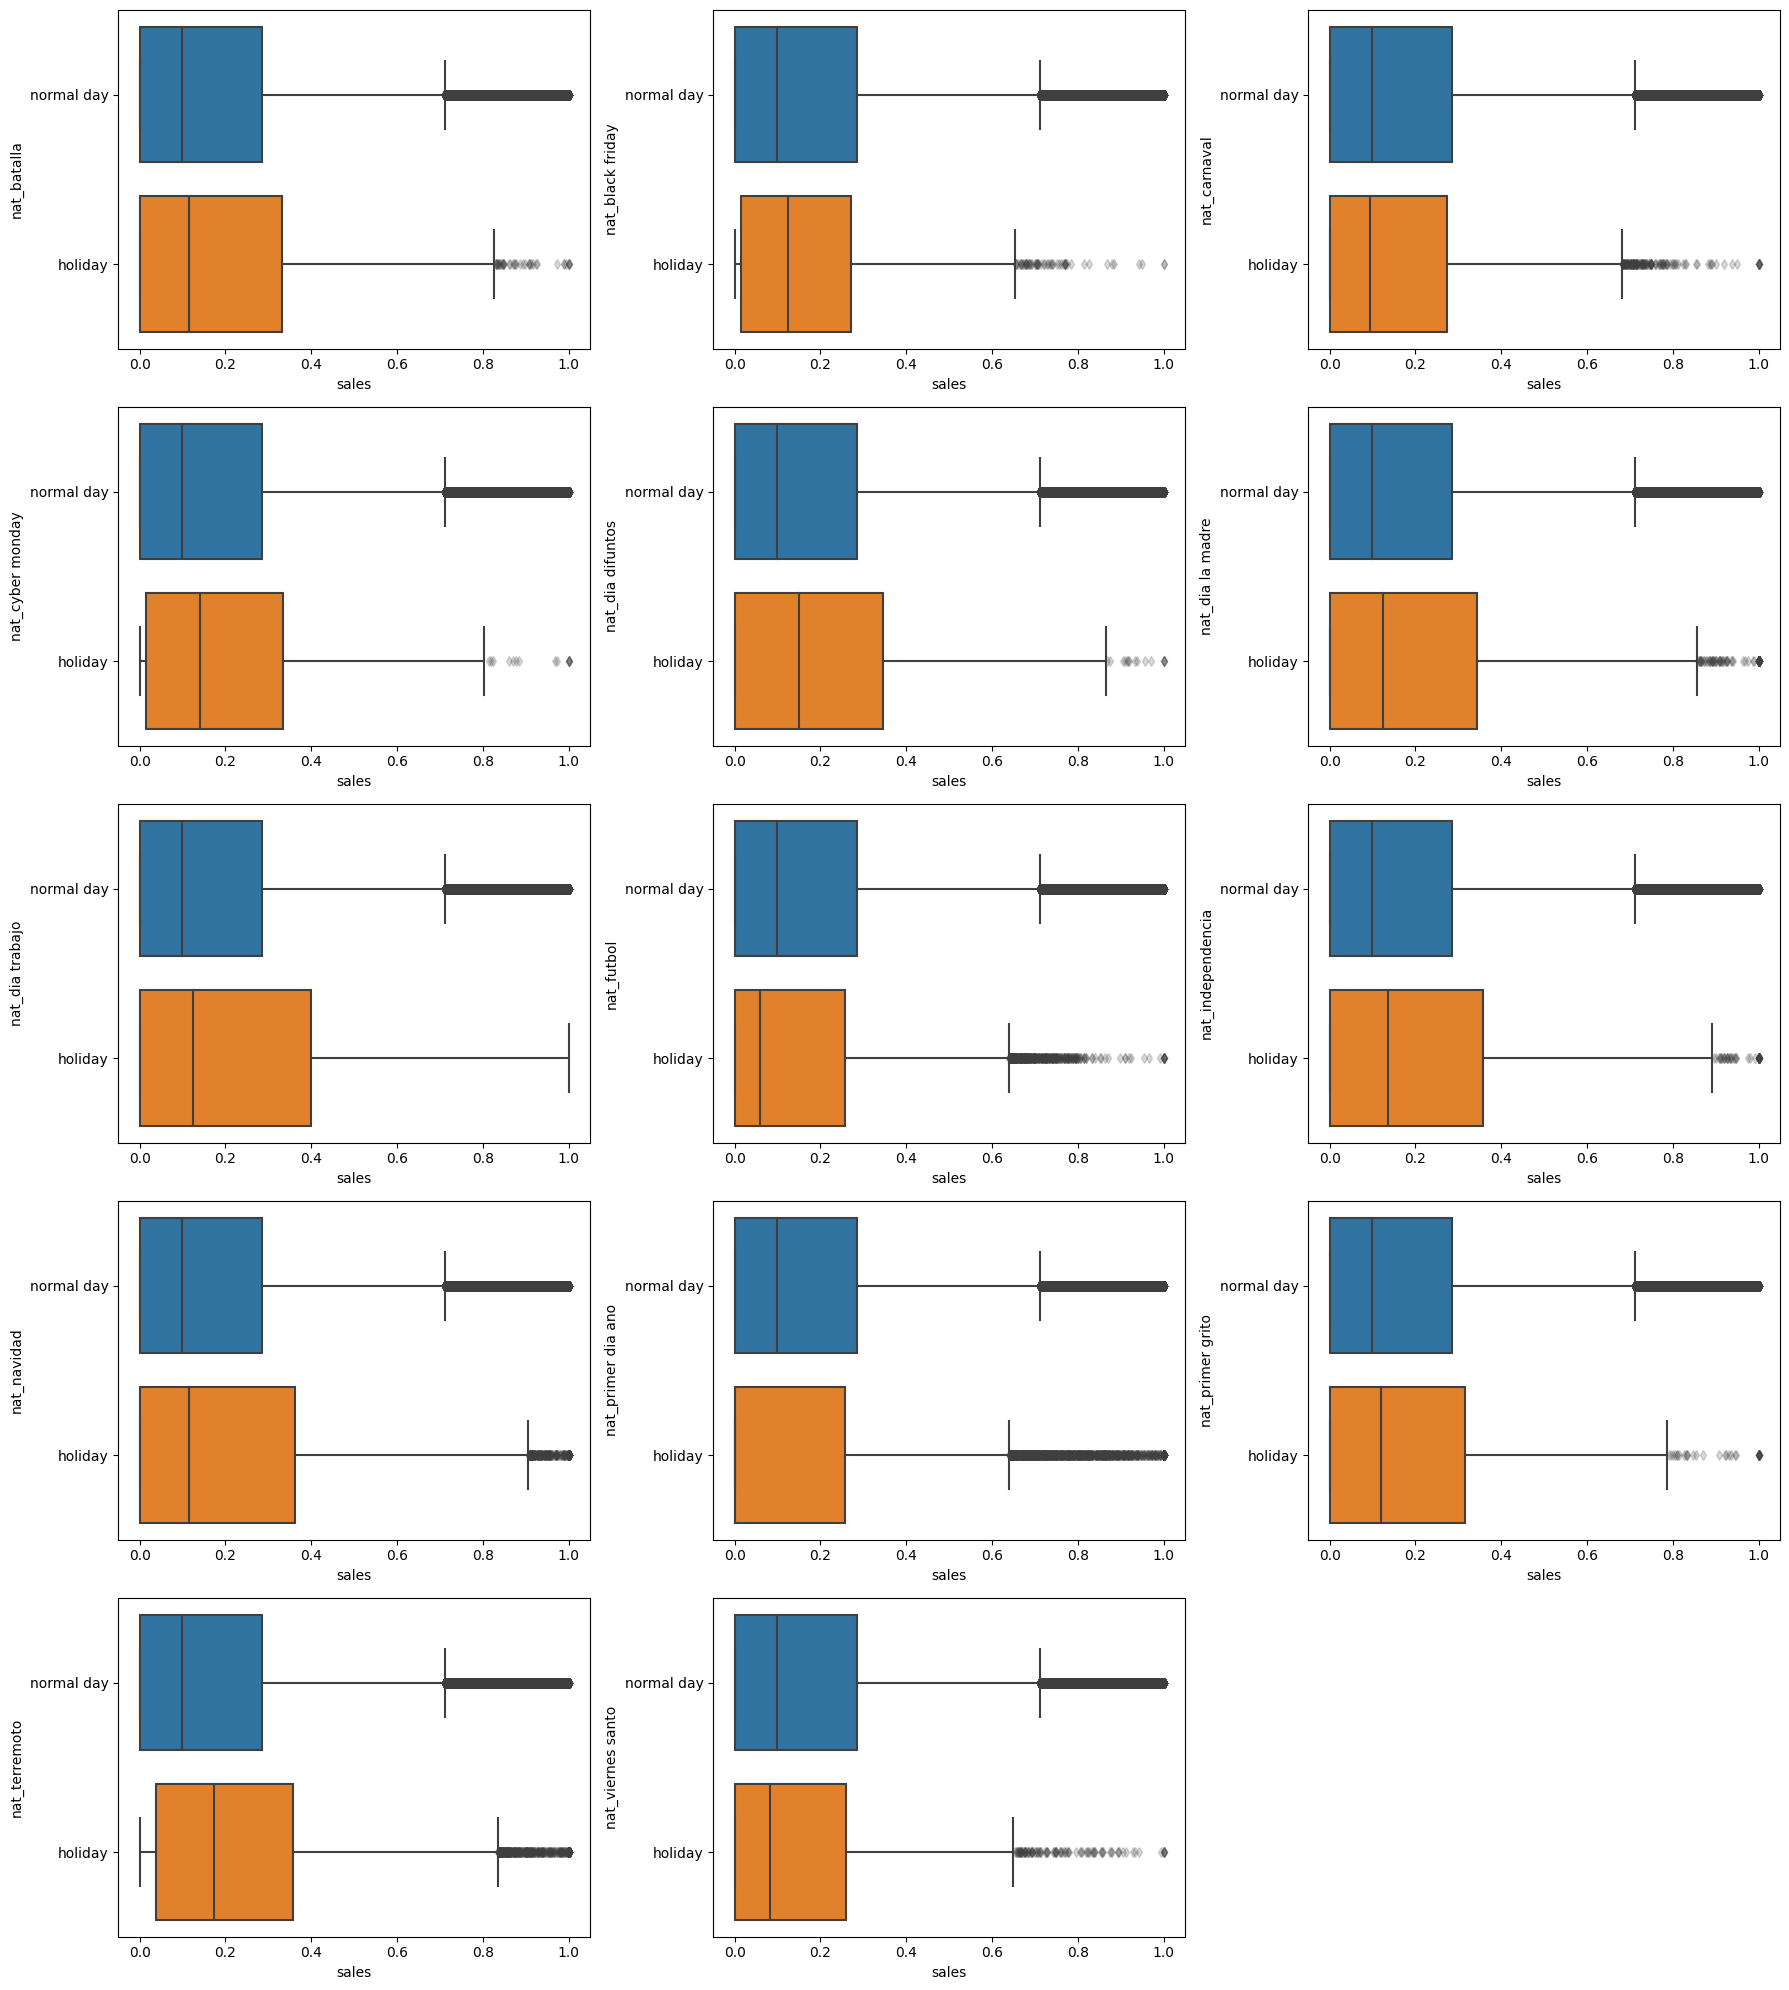

In [70]:
def plot_national_holiday_distribution():
    df = holiday_sales_merged.copy()    
    holiday_list = national_holidays.columns[1:]  
    
    plot_kwargs = {
        "flierprops": {"alpha": 0.2},
        "orient": "h"
    }
    
    fig = plt.figure(figsize=(18, 20))
    for j, hol in enumerate(holiday_list):
        sns.boxplot(
            data=df[(df[hol].eq(1)) | (df.no_holiday.eq(1))],
            y=hol,
            x="sales",
            ax=fig.add_subplot(5, 3, j+1),
            **plot_kwargs,
        )
        plt.yticks([0, 1], ["normal day", "holiday"])   
    plt.tight_layout()
    plt.show()

plot_national_holiday_distribution()

**Merge Data**

In [71]:
# keep selected national holidays with larger impacts on sales
selected_holidays = ["nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos"]
keep_national_holidays = national_holidays[["date", *selected_holidays]]


In [72]:
data = pd.concat(
    [train_data, test_data], axis=0, ignore_index=True,
).merge(
    stores_data, on=["store_nbr"]
).merge(
    oil_data, on=["date"], how="left"
).merge(
    transactions_data, on=["date", 'store_nbr'], how="left"
).merge(
    work_days, on="date", how="left",    
).merge(
    keep_national_holidays, on=["date"],how="left").sort_values(["date", "store_nbr", "family"], ignore_index=True)

In [73]:
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# Date

In [74]:
## Select the date, days of the week, hours, month  !not used in calculations
data['day_of_week'] = data.date.dt.dayofweek
data['day_of_year'] = data.date.dt.dayofyear
data['day_of_month'] = data.date.dt.day
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
#seasons 0-winter;1-spring;2-summer;3-fall
data["season"] = np.where(data.date.dt.month.isin([12,1,2]), 0, 1)
data["season"] = np.where(data.date.dt.month.isin([3,4,5]), 1, data["season"])
data["season"] = np.where(data.date.dt.month.isin([6,7,8]), 2, data["season"])
data["season"] = np.where(data.date.dt.month.isin([9, 10, 11]), 3, data["season"])
data.head()


date  store_nbr      family   id  sales  onpromotion  test   city  \
0 2013-01-01          1  AUTOMOTIVE 0.00   0.00         0.00     0  Quito   
1 2013-01-01          1   BABY CARE 1.00   0.00         0.00     0  Quito   
2 2013-01-01          1      BEAUTY 2.00   0.00         0.00     0  Quito   
3 2013-01-01          1   BEVERAGES 3.00   0.00         0.00     0  Quito   
4 2013-01-01          1       BOOKS 4.00   0.00         0.00     0  Quito   

       state type  cluster  dcoilwtico  transactions  work_day  nat_terremoto  \
0  Pichincha    D       13       93.14          0.00      0.00           0.00   
1  Pichincha    D       13       93.14          0.00      0.00           0.00   
2  Pichincha    D       13       93.14          0.00      0.00           0.00   
3  Pichincha    D       13       93.14          0.00      0.00           0.00   
4  Pichincha    D       13       93.14          0.00      0.00           0.00   

   nat_navidad  nat_dia la madre  nat_dia trabajo  nat_primer dia ano  \
0         0.00              0.00             0.00                1.00   
1         0.00              0.00             0.00                1.00   
2         0.00              0.00             0.00                1.00   
3         0.00              0.00             0.00                1.00   
4         0.00              0.00             0.00                1.00   

   nat_futbol  nat_dia difuntos  day_of_week  day_of_year  day_of_month  year  \
0        0.00              0.00            1            1             1  2013   
1        0.00              0.00            1            1             1  2013   
2        0.00              0.00            1            1             1  2013   
3        0.00              0.00            1            1             1  2013   
4        0.00              0.00            1            1             1  2013   

   month  season  
0      1       0  
1      1       0  
2      1       0  
3      1       0  
4      1       0

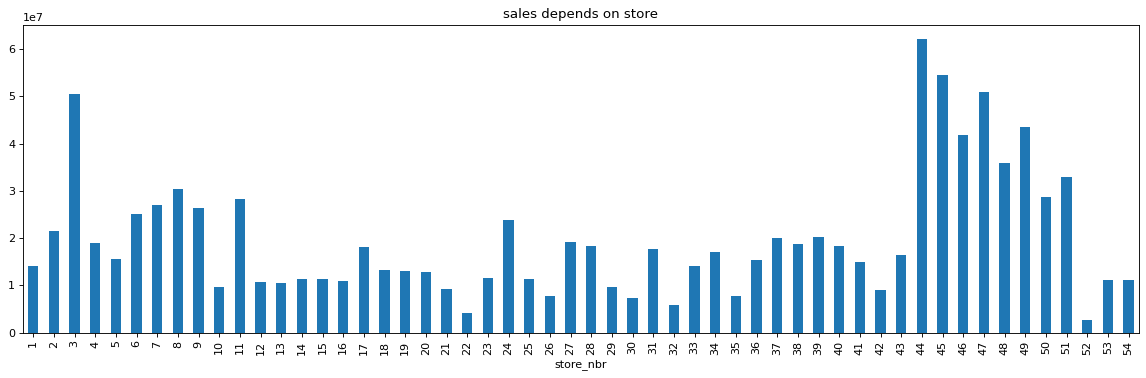

In [75]:
plt.figure(figsize=(18, 5), dpi= 80)

sales_city = data.groupby(['store_nbr'])['sales'].sum()
sales_city.plot.bar()
plt.title ("sales depends on store")
plt.show()

In [76]:
#Let's keep data for 1-20 stores, due to the lack of memory
data = data.loc[data['store_nbr'].isin(list(range(1, 19)))]

#  EDA (Exploratory Data Analysis)

In [77]:
train = data.loc[data['test'] == 0]
test = data.loc[data['test'] == 1]

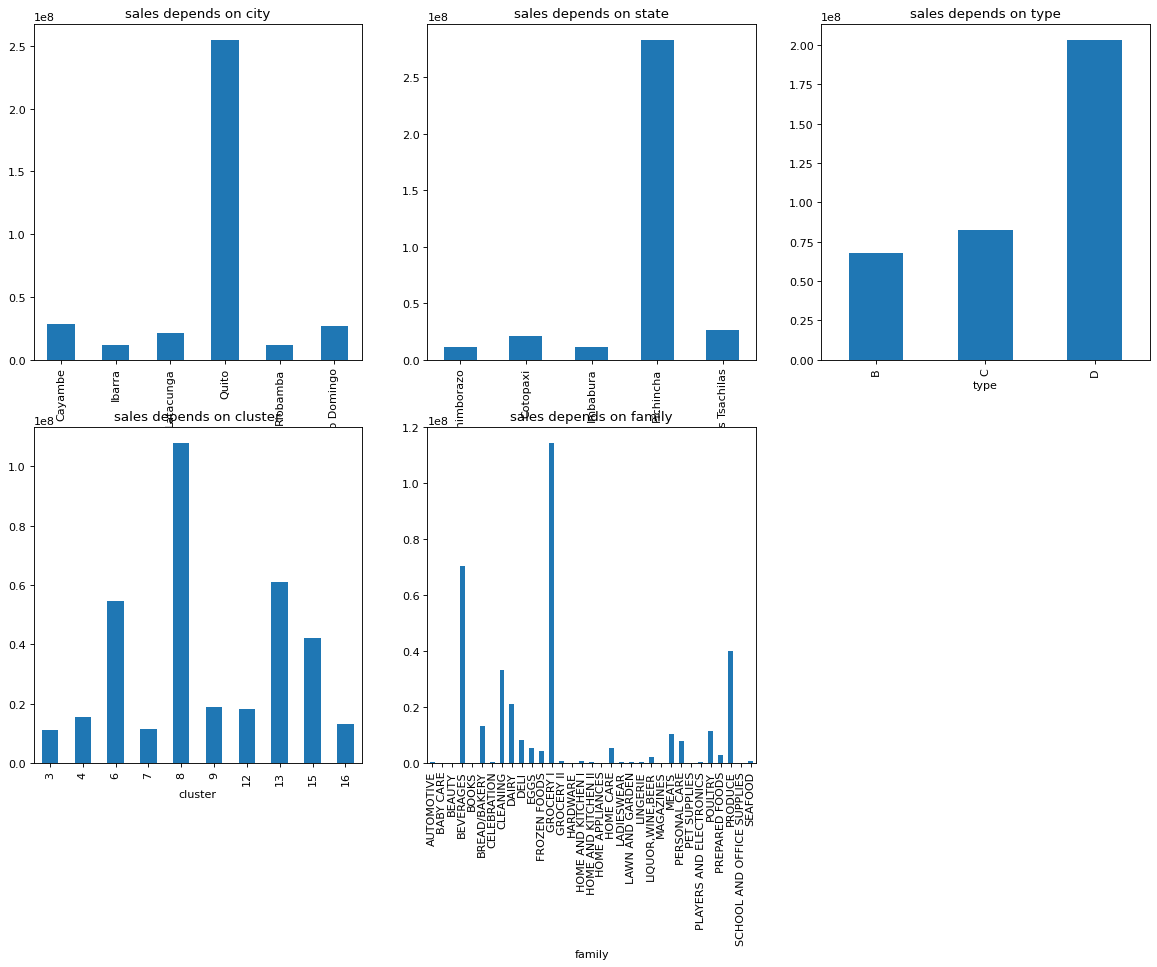

In [78]:
plt.figure(figsize=(18, 12), dpi= 80)

plt.subplot (2, 3, 1)
sales_city = train.groupby(['city'])['sales'].sum()
sales_city.plot.bar()
plt.title ("sales depends on city")

plt.subplot (2, 3, 2)
sales_state = train.groupby(['state'])['sales'].sum()
sales_state.plot.bar()
plt.title ("sales depends on state")

plt.subplot (2, 3, 3)
sales_type = train.groupby(['type'])['sales'].sum()
sales_type.plot.bar()
plt.title ("sales depends on type")

plt.subplot (2, 3, 4)
sales_cluster = train.groupby(['cluster'])['sales'].sum()
sales_cluster.plot.bar()
plt.title ("sales depends on cluster")

plt.subplot (2, 3, 5)
sales_type_y = train.groupby(['family'])['sales'].sum()
sales_type_y.plot.bar()
plt.title ("sales depends on family")
plt.show()

sales depend on the types of stores

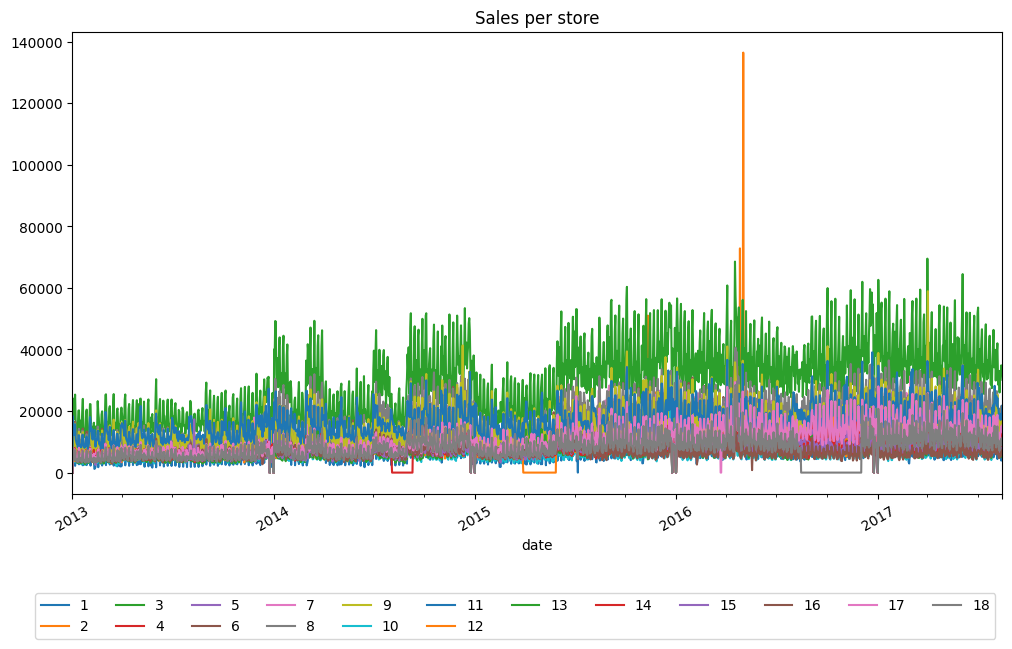

In [79]:
sale_store = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
sale_store = sale_store.pivot(index='date', columns='store_nbr', values='sales')
sale_store.plot(figsize=(12, 6))
plt.title("Sales per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12)
plt.show()

on the chart we can observe a point with abnormal sales in 2016 for the certain stores

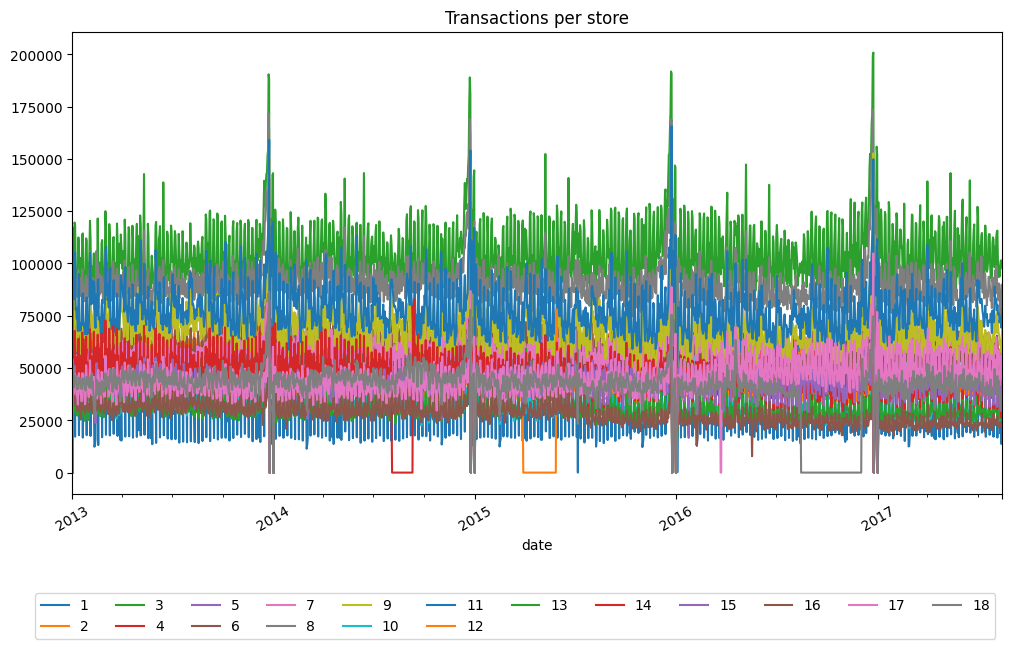

In [80]:
tr_store = train.groupby(['date','store_nbr'], as_index=False)['transactions'].sum()
tr_store = tr_store.pivot(index='date', columns='store_nbr', values='transactions')
tr_store.plot(figsize=(12, 6))
plt.title("Transactions per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12) 
plt.show()

**Family**

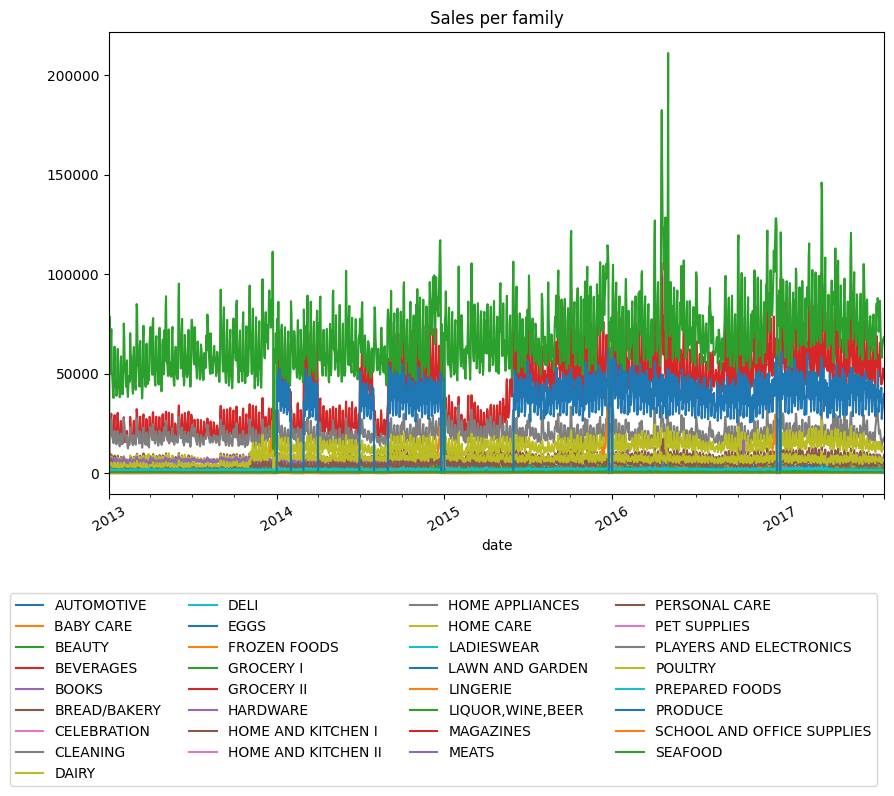

In [81]:
### Let's build average target curves by hours for each day of the week
sale_family = train.groupby(['date','family'], as_index=False)['sales'].sum()
sale_family = sale_family.pivot(index='date', columns='family', values='sales')
sale_family.plot(figsize=(10, 6))
plt.title("Sales per family", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=4)
plt.show()

**Timeline Sales**

In [82]:
list_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_months = ['January','February','March','April','May','June','July','August','September','October','November','December'] 
list_years = ['2013','2014','2015','2016','2017']

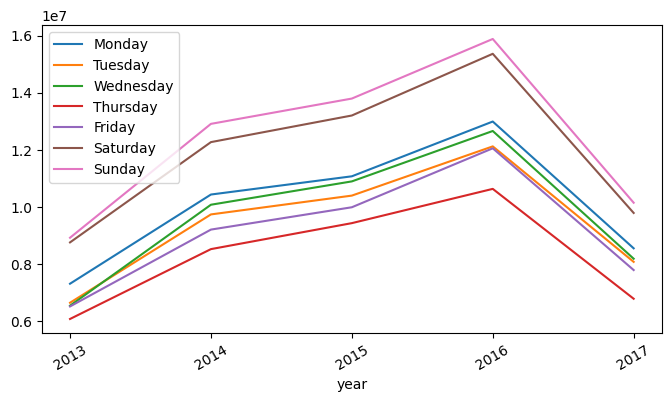

In [83]:
frame1 = train.groupby(['day_of_week', 'year'], as_index=False)['sales'].sum()
frame1 = frame1.pivot(index='year', columns='day_of_week', values='sales')
frame1.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_days)
plt.show()

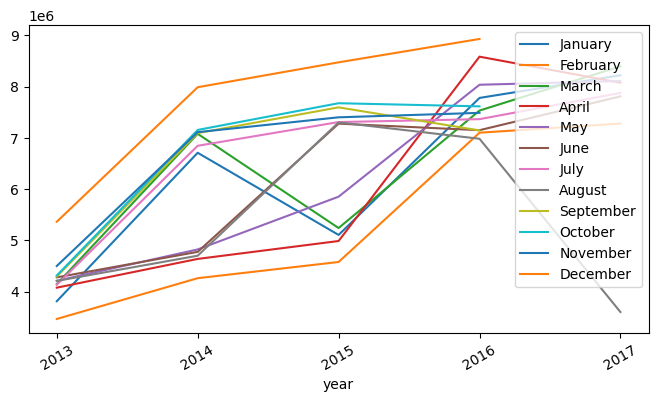

In [84]:
frame4 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame4 = frame4.pivot(index='year', columns='month', values='sales')
frame4.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_months)
plt.show()

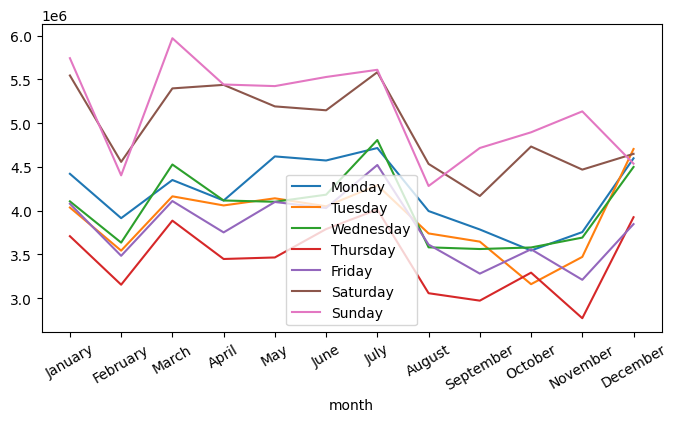

In [85]:
frame2 = train.groupby(['day_of_week', 'month'], as_index=False)['sales'].sum()
frame2 = frame2.pivot(index='month', columns='day_of_week', values='sales')
frame2.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months,rotation=30)
plt.legend(list_days)
plt.show()

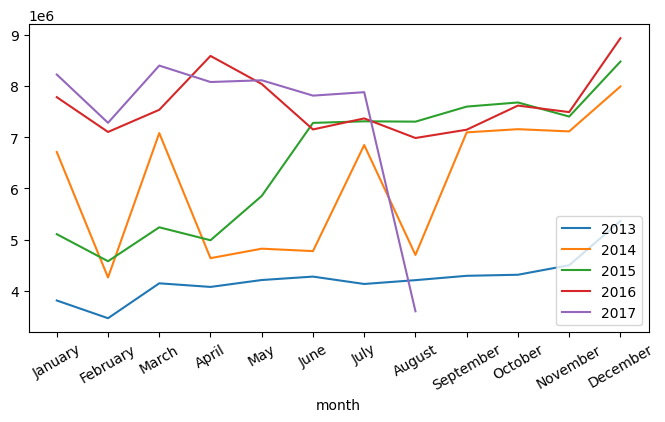

In [86]:
frame3 = train.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame3 = frame3.pivot(index='month', columns='year', values='sales')
frame3.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months, rotation=30)
plt.legend(list_years)


plt.show()

we can notice that sales from year to year during the week maintain their trends and there is a gradual increase
by month the dependence is less obvious but there is an increasing trend
the last two graphs do not allow us to draw any meaningful conclusions

**What products are affected by discounts?**

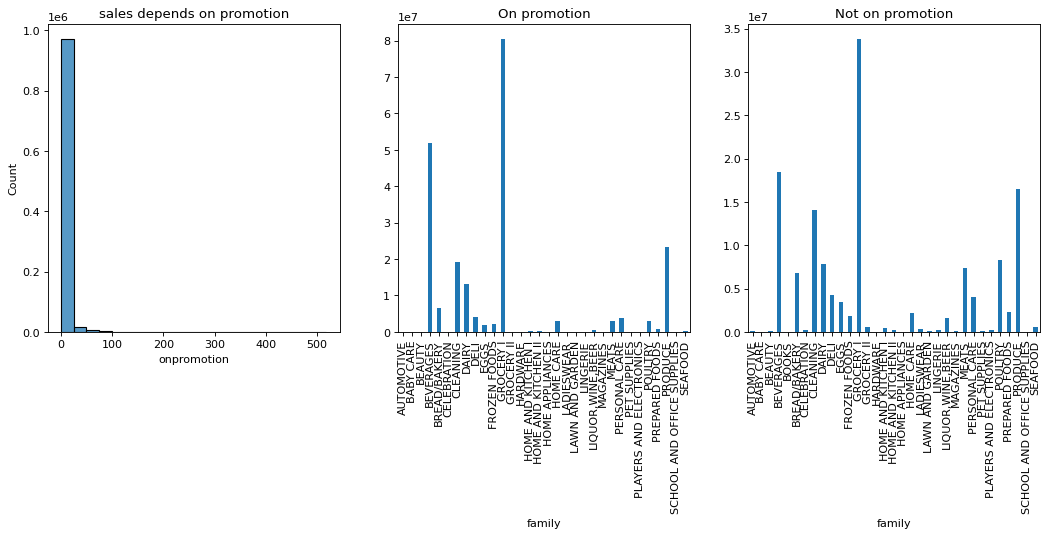

In [87]:
plt.figure(figsize=(16, 5), dpi= 80)

plt.subplot (1, 3, 1)
sns.histplot(data=train, x='onpromotion')
plt.title ("sales depends on promotion")

plt.subplot (1, 3, 2)
data_promo_yes = train.copy()
data_promo_yes = data_promo_yes[data_promo_yes['onpromotion']!=0]
data_promo_yes = data_promo_yes.groupby(['family'])['sales'].sum()
data_promo_yes.plot.bar()
plt.title ("On promotion")

plt.subplot (1, 3, 3)
data_promo_no = train.copy()
data_promo_no = data_promo_no[data_promo_no['onpromotion']==0]
data_promo_no = data_promo_no.groupby(['family'])['sales'].sum()
data_promo_no.plot.bar()
plt.title ("Not on promotion")

plt.show()

 for many categories of goods, demand increases depending on whether it participates in promotions

**Correlation of oil prices and sales/promotions/transactions**

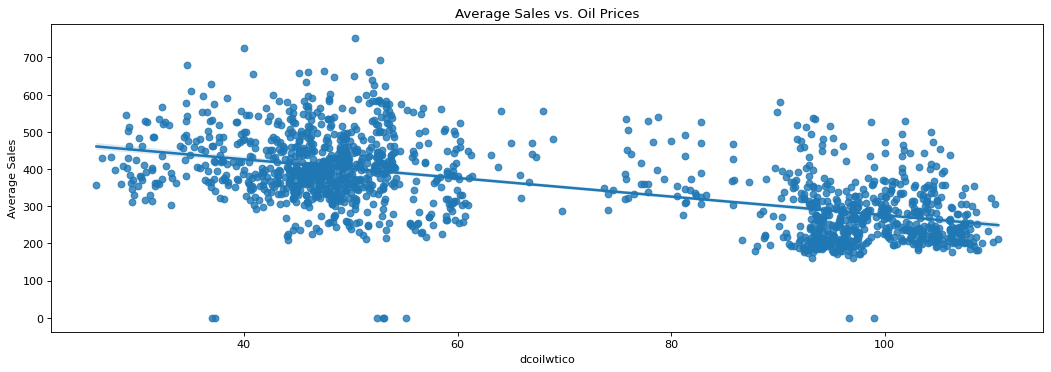

In [88]:
data_sales_oil = train.copy()
data_sales_oil = data_sales_oil.groupby(['dcoilwtico'], as_index=False)['sales'].mean()

plt.figure(figsize=(16, 5), dpi= 80)
sns.regplot(x=data_sales_oil.dcoilwtico, y=data_sales_oil.sales)
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Oil Prices")
plt.show()

the more expensive oil is, the fewer sales

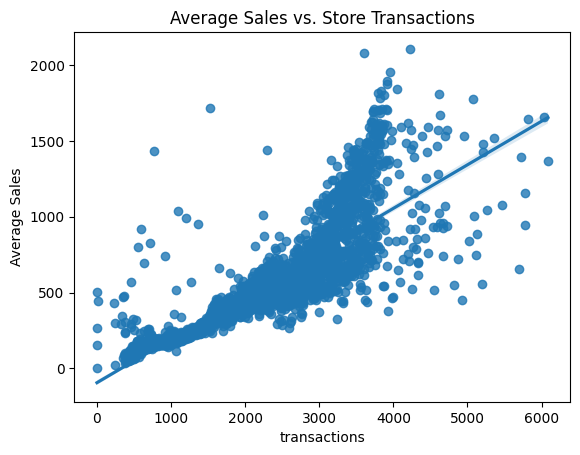

In [89]:
data_sales_tr = train.copy()
data_sales_tr = data_sales_tr.groupby(['transactions'], as_index=False)['sales'].mean()

sns.regplot(x=data_sales_tr.transactions, y=data_sales_tr.sales)
plt.xlabel("transactions")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Store Transactions")
plt.show()

the number of sales increases with the number of transactions, which is quite expected

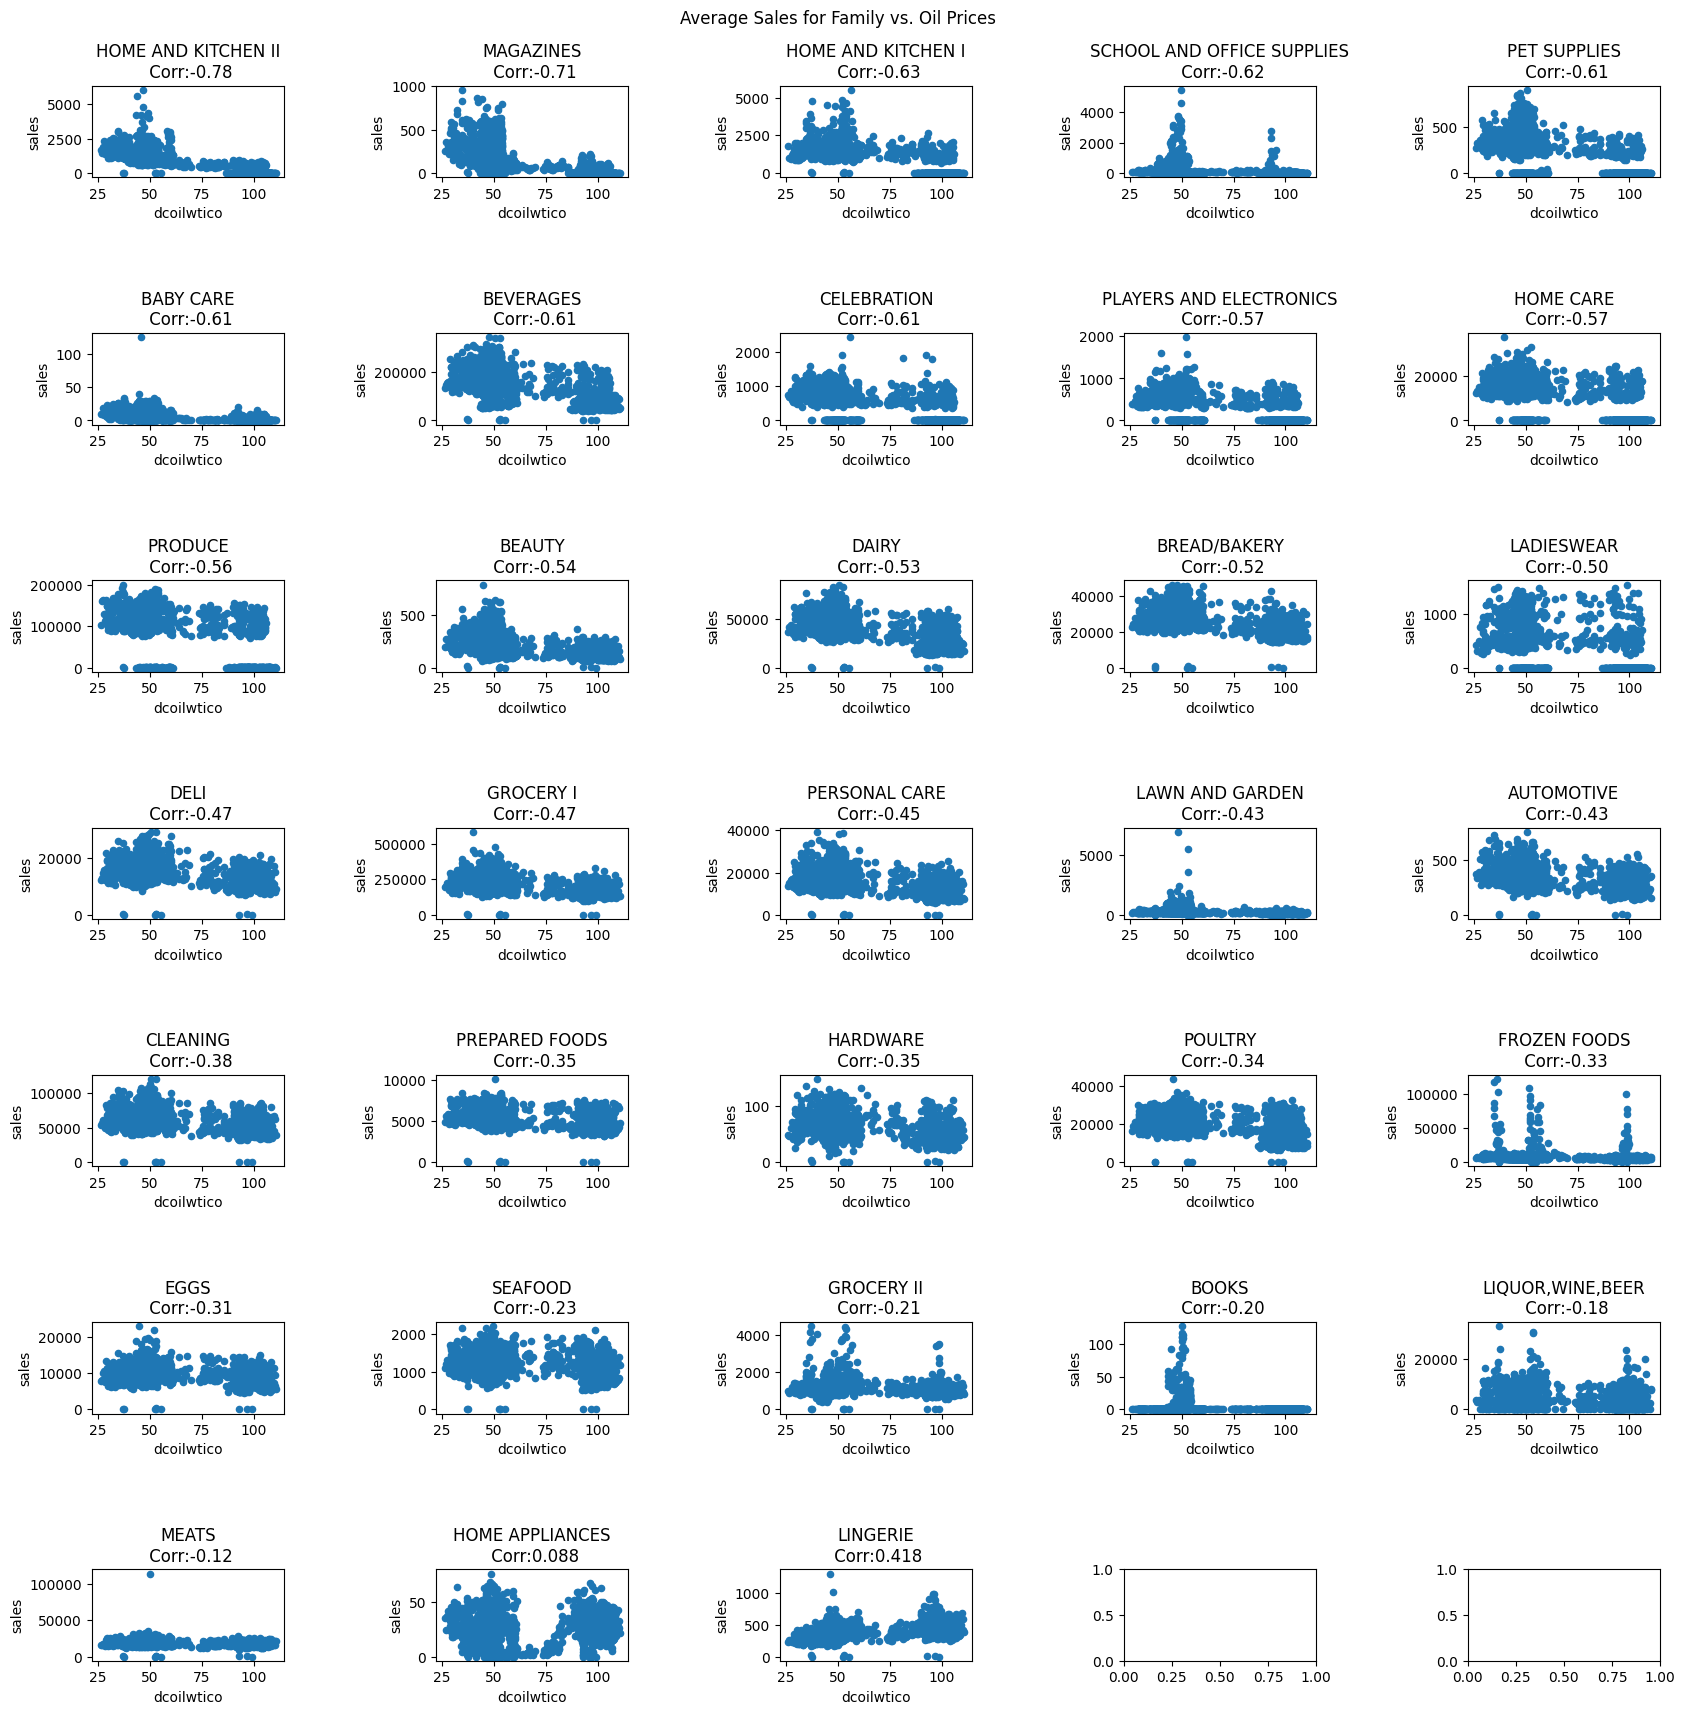

In [90]:
df_train_oil = pd.merge(train_data.groupby(["date", "family"])['sales'].sum().reset_index(),
             oil_data, how="left")
corr_train_oil = df_train_oil.groupby("family").corr("spearman").reset_index()
corr_train_oil = corr_train_oil[corr_train_oil[
    'level_1'] == "dcoilwtico"][["family", "sales"]].sort_values("sales")
    
fig, axes = plt.subplots(7, 5, figsize=(18, 18))
for i, j in enumerate(corr_train_oil['family']):
    df_train_oil[df_train_oil['family'] == j].plot.scatter(x="dcoilwtico", y="sales", ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(j + "\n Corr:" + str(
        corr_train_oil[corr_train_oil.family == j].sales.iloc[0])[:5])

plt.tight_layout(pad=5)
plt.suptitle("Average Sales for Family vs. Oil Prices \n")
plt.show()

**Seasonality**

In [91]:
data_seasons = train.copy()
data_winter = data_seasons[data_seasons['season']==0]
data_spring = data_seasons[data_seasons['season']==1]
data_summer = data_seasons[data_seasons['season']==2]
data_fall = data_seasons[data_seasons['season']==3]

sales_family_winter = data_winter.groupby(['family'])['sales'].sum().reset_index()
sales_family_spring = data_spring.groupby(['family'])['sales'].sum().reset_index()
sales_family_summer = data_summer.groupby(['family'])['sales'].sum().reset_index()
sales_family_fall = data_fall.groupby(['family'])['sales'].sum().reset_index()

sales_family_winter = sales_family_winter.rename(columns = {"sales": "sales_winter"})
sales_family_spring = sales_family_spring.rename(columns = {"sales": "sales_spring"})
sales_family_summer = sales_family_summer.rename(columns = {"sales": "sales_summer"})
sales_family_fall = sales_family_fall.rename(columns = {"sales": "sales_fall"})

df_all_seasons = sales_family_winter.merge(
    sales_family_spring, on=["family"]).merge(
    sales_family_summer, on=["family"]).merge(
    sales_family_fall, on=["family"])

df_all_seasons.head()

family  sales_winter  sales_spring  sales_summer  sales_fall
0  AUTOMOTIVE      41574.00      45796.00      43230.00    34774.00
1   BABY CARE       1001.00       1114.00       1489.00     1060.00
2      BEAUTY      26919.00      27728.00      29905.00    23689.00
3   BEVERAGES   17366197.00   18216018.00   18207011.00 16561615.00
4       BOOKS        771.00        291.00         41.00      987.00

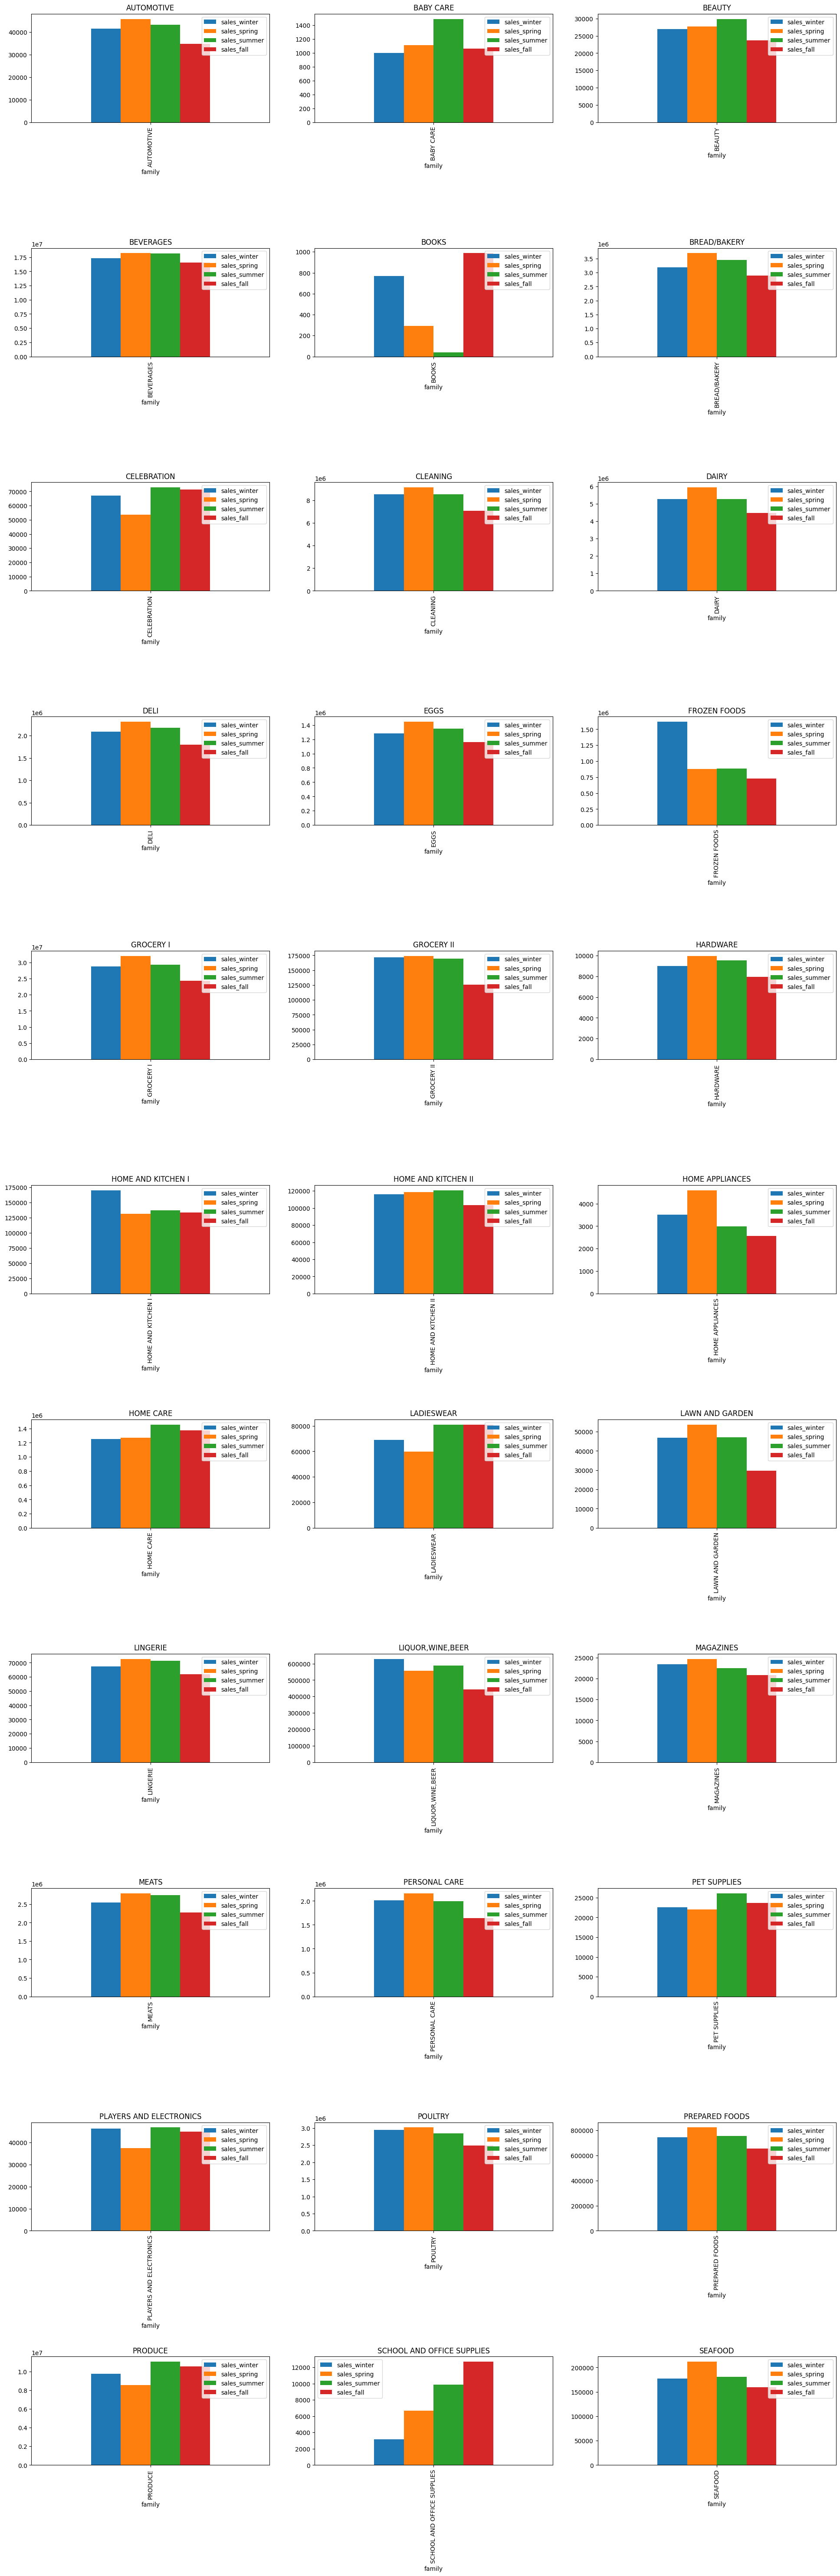

In [92]:
# plot data in grouped manner of bar type
fig, axes = plt.subplots(11, 3, figsize=(20, 60))
for i, j in enumerate(df_all_seasons['family']):
    df_all_seasons[df_all_seasons['family'] == j].plot(
        x='family', kind='bar',stacked=False,ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(j)

plt.tight_layout(pad=3)
plt.show()

we can observe how sales of different categories of goods change depending on the season, on the basis of which we can conclude that this is an important feature

**Promotions**

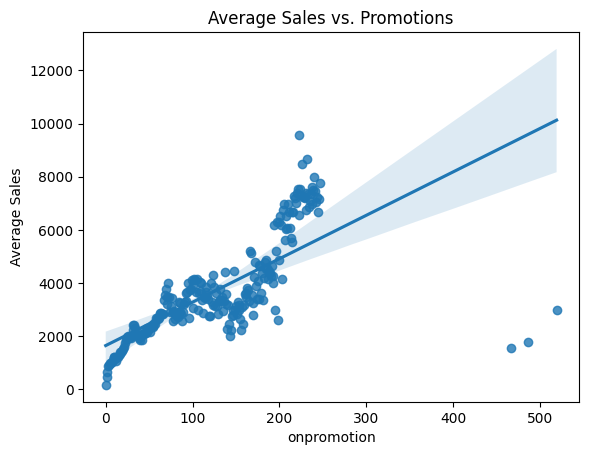

In [93]:
data_sales_prom = train.copy()
data_sales_prom = data_sales_prom.groupby(['onpromotion'], as_index=False)['sales'].mean()

sns.regplot(x=data_sales_prom.onpromotion, y=data_sales_prom.sales)
plt.xlabel("onpromotion")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Promotions")
plt.show()

an increase in sales with an increase in the number of products on promotions

In [94]:
del data_sales_prom,df_all_seasons,sales_family_winter,sales_family_spring,sales_family_summer,sales_family_fall,data_winter,data_spring,data_summer,data_fall

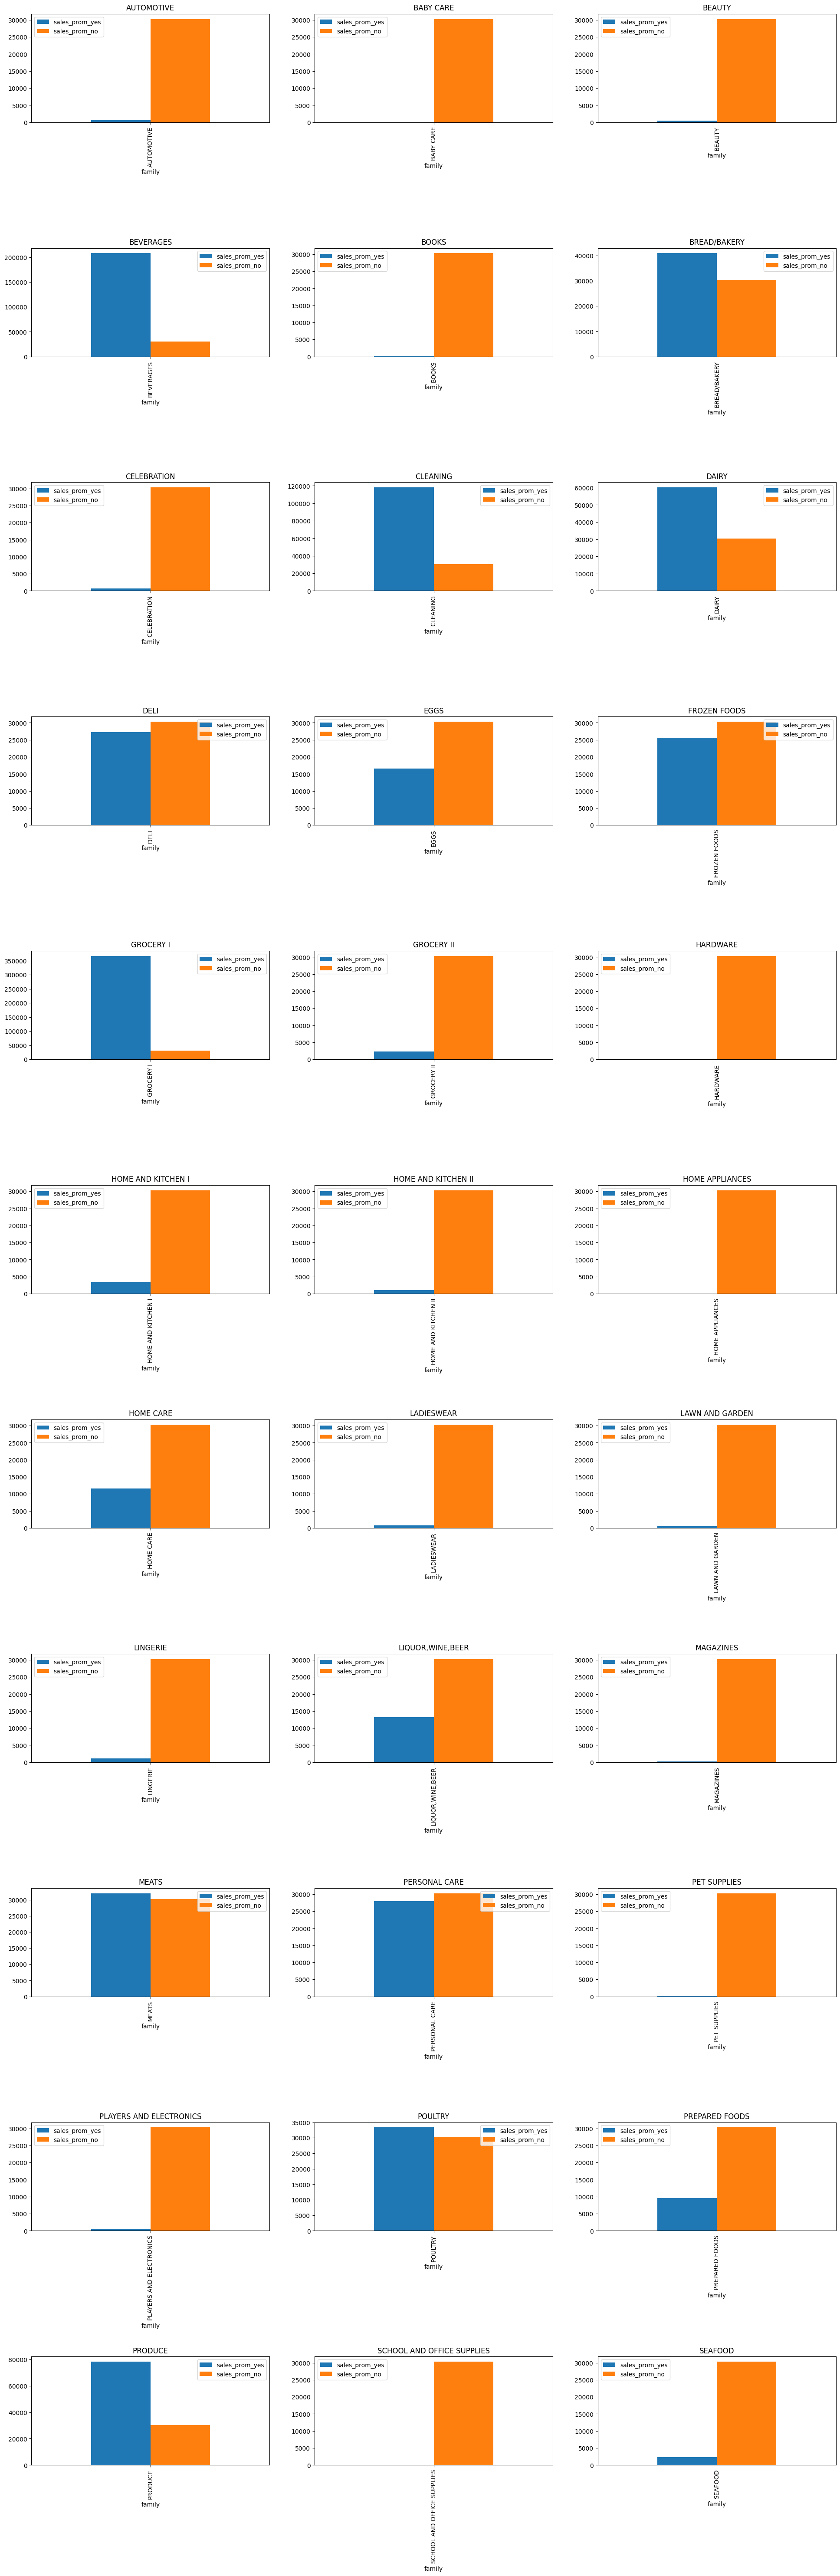

In [95]:
data_prom = train.copy()
data_prom_yes = data_prom[data_prom['work_day']!=0]
data_prom_yes_sum = data_prom_yes.groupby([
    'family'])['sales'].sum().reset_index().rename(columns = {"sales": "sales_prom_yes"})

data_prom_no = data_prom[data_prom['work_day']==0]
data_prom_no_sum = data_prom_no.groupby([
    'family'])['sales'].count().reset_index().rename(columns = {"sales": "sales_prom_no"})

df_prom = data_prom_yes_sum.merge(data_prom_no_sum, on=["family"])

fig, axes = plt.subplots(11, 3, figsize=(20, 60))

for i, j in enumerate(df_prom['family']):
    df_prom[df_prom['family'] == j].plot(x='family', kind='bar',stacked=False,
                                         ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(j)

plt.tight_layout(pad=3)
plt.show()

In [96]:
del data_prom, data_prom_yes, data_prom_yes_sum, data_prom_no, data_prom_no_sum, df_prom

Analyze outliers in the data

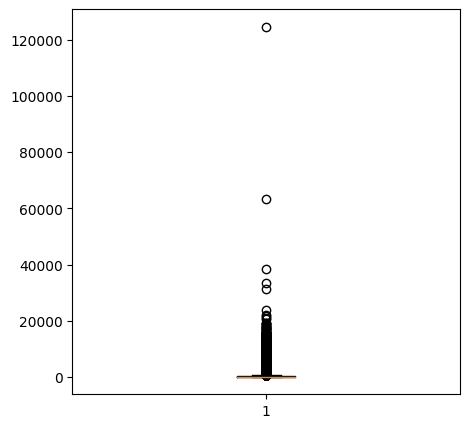

In [97]:
fig = plt.figure()
fig.set_size_inches((5, 5))
plt.boxplot(train['sales'].values)

plt.show()

Heatmap with correlation matrix

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002672 entries, 0 to 3006827
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1002672 non-null  datetime64[ns]
 1   store_nbr           1002672 non-null  int64         
 2   family              1002672 non-null  object        
 3   id                  1002672 non-null  float64       
 4   sales               1002672 non-null  float64       
 5   onpromotion         1002672 non-null  float64       
 6   test                1002672 non-null  int64         
 7   city                1002672 non-null  object        
 8   state               1002672 non-null  object        
 9   type                1002672 non-null  object        
 10  cluster             1002672 non-null  int64         
 11  dcoilwtico          1002672 non-null  float64       
 12  transactions        1002672 non-null  float64       
 13  work_day         

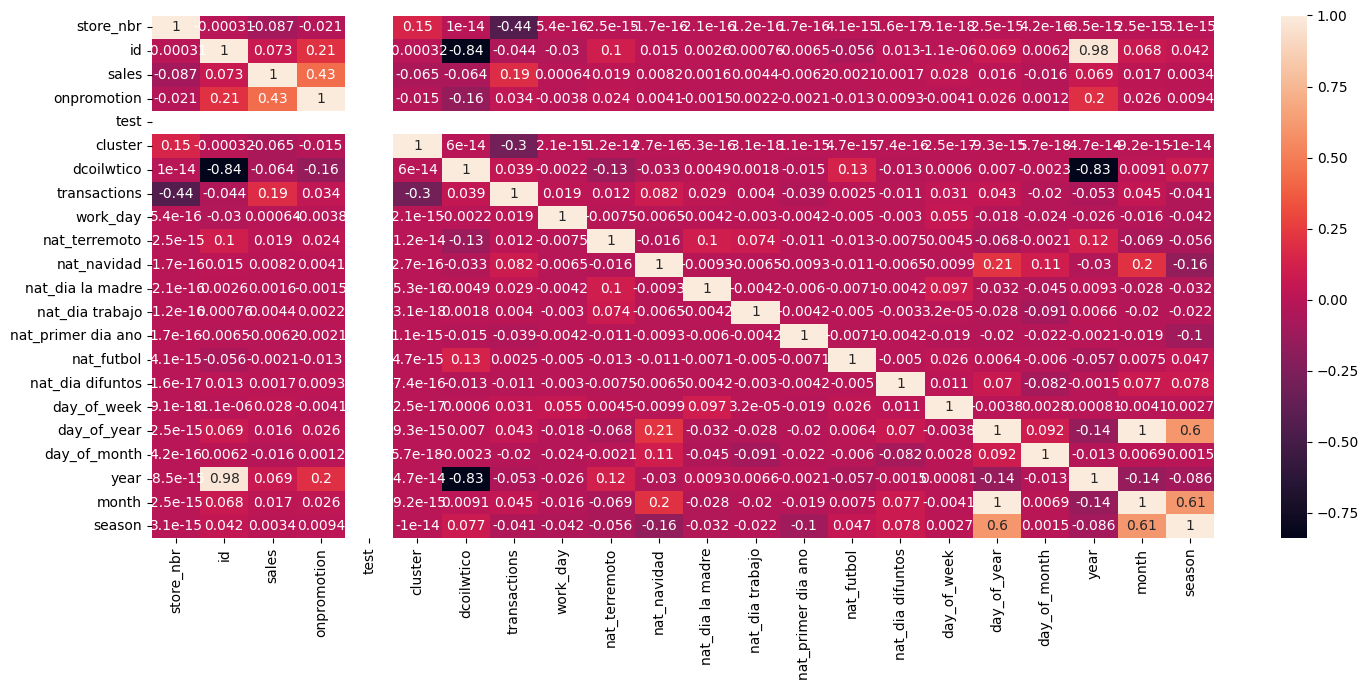

In [99]:
plt.figure(figsize=(15, 7))
numeric_columns = train.select_dtypes(include=['number']).columns
sns.heatmap(train[numeric_columns].corr(), annot=True)
plt.tight_layout()
plt.show()


In [100]:
data_analyses = data.copy()

target = 'sales'
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

In [101]:
def CompareTwoGroups(dataframe, group, target):
    # Create Combinations
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    AB = pd.DataFrame()
    for i in range(0, len(item_comb)):
        # Define Groups
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        # Assumption: Normality
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is Normal! - False
        # H1: Distribution is not Normal! - True
        if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
            # Parametric Test
            # Assumption: Homogeneity of variances
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity: False
            # H1: Heterogeneous: True
            if leveneTest == False:
                # Homogeneity
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
            else:
                # Heterogeneous
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 = M2 - False
                # H1: M1 != M2 - True
        else:
            # Non-Parametric Test
            ttest = stats.mannwhitneyu(groupA, groupB)[1] 
            # H0: M1 = M2 - False
            # H1: M1 != M2 - True
            
        temp = pd.DataFrame({"Compare Two Groups":[ttest < 0.05], 
                             "p-value":[ttest],
                             "GroupA_Mean":[groupA.mean()], 
                             "GroupB_Mean":[groupB.mean()],
                             "GroupA_Median":[groupA.median()], 
                             "GroupB_Median":[groupB.median()],
                             "GroupA_Count":[groupA.count()], 
                             "GroupB_Count":[groupB.count()]}, index = [item_comb[i]])
        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"] == True, 
                                              "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[["TestType", "Compare Two Groups", 
                                  "p-value","GroupA_Median", "GroupB_Median",
                                  "GroupA_Mean", "GroupB_Mean",
                                  "GroupA_Count", "GroupB_Count"]]])   
    return AB

CompareTwoGroups(train, group = "store_nbr", target = "sales")

TestType Compare Two Groups  p-value  GroupA_Median  \
(1, 2)    Non-Parametric   Different Groups     0.00          18.55   
(1, 3)    Non-Parametric   Different Groups     0.00          18.55   
(1, 4)    Non-Parametric   Different Groups     0.00          18.55   
(1, 5)    Non-Parametric   Different Groups     0.00          18.55   
(1, 6)    Non-Parametric   Different Groups     0.00          18.55   
...                  ...                ...      ...            ...   
(15, 17)  Non-Parametric   Different Groups     0.00           8.00   
(15, 18)  Non-Parametric     Similar Groups     0.39           8.00   
(16, 17)  Non-Parametric   Different Groups     0.00           6.00   
(16, 18)  Non-Parametric   Different Groups     0.00           6.00   
(17, 18)  Non-Parametric   Different Groups     0.00          10.00   

          GroupB_Median  GroupA_Mean  GroupB_Mean  GroupA_Count  GroupB_Count  
(1, 2)            23.00       253.93       387.00         55704         55704  
(1, 3)            63.00       253.93       906.25         55704         55704  
(1, 4)            19.00       253.93       339.47         55704         55704  
(1, 5)            19.00       253.93       279.92         55704         55704  
(1, 6)            28.00       253.93       452.10         55704         55704  
...                 ...          ...          ...           ...           ...  
(15, 17)          10.00       205.57       323.69         55704         55704  
(15, 18)           8.00       205.57       238.03         55704         55704  
(16, 17)          10.00       197.23       323.69         55704         55704  
(16, 18)           8.00       197.23       238.03         55704         55704  
(17, 18)           8.00       323.69       238.03         55704         55704  

[153 rows x 9 columns]

In [102]:
# Rolling Summary Stats Features
#A rolling mean is simply the mean of a certain number of previous periods in a time series.
for i in [16,17,18,19,20,21,22,46,76,106,365, 730]:
    data_analyses["sales_roll_mean_"+str(i)]=data_analyses.groupby(
        ["store_nbr", "family"])['sales'].rolling(i).mean().shift(1).values
    
# 2. Hypothesis Testing: Similarity
# Store Based
storesales = train.groupby(["date", "store_nbr"])['sales'].sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store_nbr", target="sales")
del storesales
#Let's find similar groups
ctg_ss[ctg_ss["Compare Two Groups"] == "Similar Groups"]

TestType Compare Two Groups  p-value  GroupA_Median  \
(12, 16)  Non-Parametric     Similar Groups     0.61        6386.87   
(14, 15)  Non-Parametric     Similar Groups     0.16        6529.03   

          GroupB_Median  GroupA_Mean  GroupB_Mean  GroupA_Count  GroupB_Count  
(12, 16)        6146.28      6314.70      6508.54          1688          1688  
(14, 15)        6826.27      6746.40      6783.93          1688          1688

In [103]:
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([12,16]), 1, 0)
data_analyses["StoreSalesSimilarity"] = np.where(data_analyses["store_nbr"].isin([14,15]), 2, data_analyses["StoreSalesSimilarity"])

#Now let's filter the results by similarity of groups when grouped by "family"
# Item Based
itemsales = train.groupby(["date", "family"])['sales'].sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "family", target = "sales")
del itemsales
ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

TestType  \
(CELEBRATION, LINGERIE)                        Non-Parametric   
(GROCERY II, HOME AND KITCHEN I)               Non-Parametric   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)  Non-Parametric   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)     Non-Parametric   
(MAGAZINES, PET SUPPLIES)                      Non-Parametric   

                                              Compare Two Groups  p-value  \
(CELEBRATION, LINGERIE)                           Similar Groups     0.15   
(GROCERY II, HOME AND KITCHEN I)                  Similar Groups     0.87   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)     Similar Groups     0.05   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)        Similar Groups     0.26   
(MAGAZINES, PET SUPPLIES)                         Similar Groups     0.69   

                                               GroupA_Median  GroupB_Median  \
(CELEBRATION, LINGERIE)                               184.00         157.00   
(GROCERY II, HOME AND KITCHEN I)                      359.00         376.00   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)           8.00           7.00   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)             82.00         127.00   
(MAGAZINES, PET SUPPLIES)                              26.50          66.00   

                                               GroupA_Mean  GroupB_Mean  \
(CELEBRATION, LINGERIE)                             156.99       161.87   
(GROCERY II, HOME AND KITCHEN I)                    379.52       339.36   
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)         8.09        19.18   
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)          104.91       103.80   
(MAGAZINES, PET SUPPLIES)                            54.12        55.95   

                                               GroupA_Count  GroupB_Count  
(CELEBRATION, LINGERIE)                                1688          1688  
(GROCERY II, HOME AND KITCHEN I)                       1688          1688  
(HOME APPLIANCES, SCHOOL AND OFFICE SUPPLIES)          1688          1688  
(LAWN AND GARDEN, PLAYERS AND ELECTRONICS)             1688          1688  
(MAGAZINES, PET SUPPLIES)                              1688          1688

In [104]:
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['CELEBRATION', 'LINGERIE']), 1, 0)
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['GROCERY II', 'HOME AND KITCHEN I']), 2, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['HOME APPLIANCES', 'SCHOOL AND OFFICE SUPPLIES']), 3, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS']), 4, data_analyses["ItemSalesSimilarity"])
data_analyses["ItemSalesSimilarity"] = np.where(data_analyses['family'].isin(['MAGAZINES', 'PET SUPPLIES']), 5, data_analyses["ItemSalesSimilarity"])

In [105]:
data_analyses.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)

In [106]:
def lag_features(dataframe, lags, groups = ["store_nbr", "family"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

#Let's create lags
data_analyses = lag_features(data_analyses, 
                             lags = [16,17,18,19,20,21,22,46,76,106,365, 730],
                             groups = ["store_nbr", "family"], target = 'sales', 
                             prefix = 'sales_lag_')
data_analyses

date  store_nbr      family         id  sales  onpromotion  \
0       2013-01-01          1  AUTOMOTIVE       0.00   0.00         0.00   
1782    2013-01-02          1  AUTOMOTIVE    1782.00   2.00         0.00   
3564    2013-01-03          1  AUTOMOTIVE    3564.00   3.00         0.00   
5346    2013-01-04          1  AUTOMOTIVE    5346.00   3.00         0.00   
7128    2013-01-05          1  AUTOMOTIVE    7128.00   5.00         0.00   
...            ...        ...         ...        ...    ...          ...   
3028211 2017-08-27         18     SEAFOOD 3020819.00    NaN         0.00   
3029993 2017-08-28         18     SEAFOOD 3022601.00    NaN         0.00   
3031775 2017-08-29         18     SEAFOOD 3024383.00    NaN         0.00   
3033557 2017-08-30         18     SEAFOOD 3026165.00    NaN         0.00   
3035339 2017-08-31         18     SEAFOOD 3027947.00    NaN         0.00   

         test   city      state type  cluster  dcoilwtico  transactions  \
0           0  Quito  Pichincha    D       13       93.14          0.00   
1782        0  Quito  Pichincha    D       13       93.14       2111.00   
3564        0  Quito  Pichincha    D       13       92.97       1833.00   
5346        0  Quito  Pichincha    D       13       93.12       1863.00   
7128        0  Quito  Pichincha    D       13       93.15       1509.00   
...       ...    ...        ...  ...      ...         ...           ...   
3028211     1  Quito  Pichincha    B       16       46.82           NaN   
3029993     1  Quito  Pichincha    B       16       46.40           NaN   
3031775     1  Quito  Pichincha    B       16       46.46           NaN   
3033557     1  Quito  Pichincha    B       16       45.96           NaN   
3035339     1  Quito  Pichincha    B       16       47.26           NaN   

         work_day  nat_terremoto  nat_navidad  nat_dia la madre  \
0            0.00           0.00         0.00              0.00   
1782         0.00           0.00         0.00              0.00   
3564         0.00           0.00         0.00              0.00   
5346         0.00           0.00         0.00              0.00   
7128         1.00           0.00         0.00              0.00   
...           ...            ...          ...               ...   
3028211      0.00           0.00         0.00              0.00   
3029993      0.00           0.00         0.00              0.00   
3031775      0.00           0.00         0.00              0.00   
3033557      0.00           0.00         0.00              0.00   
3035339      0.00           0.00         0.00              0.00   

         nat_dia trabajo  nat_primer dia ano  nat_futbol  nat_dia difuntos  \
0                   0.00                1.00        0.00              0.00   
1782                0.00                0.00        0.00              0.00   
3564                0.00                0.00        0.00              0.00   
5346                0.00                0.00        0.00              0.00   
7128                0.00                0.00        0.00              0.00   
...                  ...                 ...         ...               ...   
3028211             0.00                0.00        0.00              0.00   
3029993             0.00                0.00        0.00              0.00   
3031775             0.00                0.00        0.00              0.00   
3033557             0.00                0.00        0.00              0.00   
3035339             0.00                0.00        0.00              0.00   

         day_of_week  day_of_year  day_of_month  year  month  season  \
0                  1            1             1  2013      1       0   
1782               2            2             2  2013      1       0   
3564               3            3             3  2013      1       0   
5346               4            4             4  2013      1       0   
7128               5            5             5  2013      1       0   
...              ...      

In [107]:
#remove the most correlated features
def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+[
        "sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(data_analyses, "sales_lag", 6)

In [108]:
# 4. New Features -->Last i. Months 
data_analyses["monthyear"] = data_analyses.date.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24]:
    last_months = data_analyses.groupby(["store_nbr", "family", "monthyear"
                                        ]).sales.agg(["sum","mean","std","min","max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'family', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how   = "left", on = ["store_nbr", "family", "monthyear"])
del last_months, i

drop_cor(data_analyses, "last_", 6)

# Store Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["store_nbr", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store_nbr', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["store_nbr", "monthyear"])
del last_months, i

# Item Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["family", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['family', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["family", "monthyear"])
del last_months, i

# Similarity Based
for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["StoreSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = data_analyses.groupby(["ItemSalesSimilarity", "monthyear"
                                        ]).sales.agg(["sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    data_analyses = pd.merge(data_analyses, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

data_analyses.drop("monthyear", axis = 1, inplace = True)

In [109]:
# 5. New Features -->Last i. day of week
data_analyses.sort_values(["store_nbr", "family", "day_of_week", "date"], inplace = True)

data_analyses = lag_features(data_analyses, 
                             lags = np.arange(12,41, 1).tolist()+[16,46,76,106],
                             groups = ["store_nbr", "family", "day_of_week"], 
                             target = 'sales', 
                             prefix = 'dayofweek_sales_lag_')

data_analyses[data_analyses.columns[data_analyses.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(data_analyses, "dayofweek_sales_lag_", 6)

In [110]:
data_analyses.sort_values(["store_nbr", "family", "date"], inplace = True)

In [111]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)
                     ] = dataframe.groupby(["store_nbr", "family"]
                                          )['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [16,17,18,19,20,21,22,46,76,106,365, 730]

data_analyses = ewm_features(data_analyses, alphas, lags)

In [112]:
# Day of year
data_analyses.sort_values(["day_of_year", "store_nbr", "family"], inplace = True)
data_analyses = lag_features(data_analyses, 
                             lags = [1,2,3,4],
                             groups = ["day_of_year", "store_nbr", "family"], 
                             target = 'sales', 
                             prefix = 'dayofyear_sales_lag_')

# pd.cut
clus = data_analyses.groupby(["store_nbr"])['sales'].mean().reset_index()
clus["store_cluster"] =  pd.cut(clus['sales'], bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
clus = data_analyses.groupby(["family"])['sales'].mean().reset_index()
clus["family_cluster"] =  pd.cut(clus['sales'], bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
data_analyses = pd.merge(data_analyses, clus, how = "left")
del clus

data_analyses.shape

(1012176, 202)

In [113]:
# Dataframe must be sorted by date because of Time Series Split 
data_analyses = data_analyses.sort_values("date").reset_index(drop = True)

In [114]:
#Let's bring all the columns into a single form to avoid further errors
columns_old = data_analyses.columns
columns_new = [column.replace(" ", "_") for column in columns_old]
data_analyses.columns = columns_new
del columns_old, columns_new 

In [115]:
#Let's define the columns that will be further used in the analysis
features = [col for col in data_analyses.columns if col not in ['date', 'id', "sales", 'transactions',
                                                                'day_of_week','day_of_year','day_of_month',
                                                                'year', 'month', 'season','test']]

In [116]:
data_analyses

date  store_nbr                   family         id  sales  \
0       2013-01-01          1               AUTOMOTIVE       0.00   0.00   
1       2013-01-01          8            PERSONAL CARE    1741.00   0.00   
2       2013-01-01          8             PET SUPPLIES    1742.00   0.00   
3       2013-01-01          8  PLAYERS AND ELECTRONICS    1743.00   0.00   
4       2013-01-01          8                  POULTRY    1744.00   0.00   
...            ...        ...                      ...        ...    ...   
1012171 2017-08-31          7                BABY CARE 3029302.00    NaN   
1012172 2017-08-31          7                   BEAUTY 3029303.00    NaN   
1012173 2017-08-31          7                BEVERAGES 3029304.00    NaN   
1012174 2017-08-31          7             BREAD/BAKERY 3029306.00    NaN   
1012175 2017-08-31          5          HOME APPLIANCES 3029087.00    NaN   

         onpromotion  test           city                           state  \
0               0.00     0          Quito                       Pichincha   
1               0.00     0          Quito                       Pichincha   
2               0.00     0          Quito                       Pichincha   
3               0.00     0          Quito                       Pichincha   
4               0.00     0          Quito                       Pichincha   
...              ...   ...            ...                             ...   
1012171         0.00     1          Quito                       Pichincha   
1012172         1.00     1          Quito                       Pichincha   
1012173        40.00     1          Quito                       Pichincha   
1012174        10.00     1          Quito                       Pichincha   
1012175         0.00     1  Santo Domingo  Santo Domingo de los Tsachilas   

        type  cluster  dcoilwtico  transactions  work_day  nat_terremoto  \
0          D       13       93.14          0.00      0.00           0.00   
1          D        8       93.14          0.00      0.00           0.00   
2          D        8       93.14          0.00      0.00           0.00   
3          D        8       93.14          0.00      0.00           0.00   
4          D        8       93.14          0.00      0.00           0.00   
...      ...      ...         ...           ...       ...            ...   
1012171    D        8       47.26           NaN      0.00           0.00   
1012172    D        8       47.26           NaN      0.00           0.00   
1012173    D        8       47.26           NaN      0.00           0.00   
1012174    D        8       47.26           NaN      0.00           0.00   
1012175    D        4       47.26           NaN      0.00           0.00   

         nat_navidad  nat_dia_la_madre  nat_dia_trabajo  nat_primer_dia_ano  \
0               0.00              0.00             0.00                1.00   
1               0.00              0.00             0.00                1.00   
2               0.00              0.00             0.00                1.00   
3               0.00              0.00             0.00                1.00   
4               0.00              0.00             0.00                1.00   
...              ...               ...              ...                 ...   
1012171         0.00              0.00             0.00                0.00   
1012172         0.00              0.00             0.00                0.00   
1012173         0.00              0.00             0.00                0.00   
1012174         0.00              0.00             0.00                0.00   
1012175         0.00              0.00             0.00                0.00   

         nat_futbol  nat_dia_difuntos  day_of_week  day_of_year  day_of_month  \
0              0.00              0.00            1            1             1   
1              0.00              0.00            1            1             1   
2              0.00              0.00            1            1        

In [117]:
data_analyses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012176 entries, 0 to 1012175
Columns: 202 entries, date to family_cluster
dtypes: category(2), datetime64[ns](1), float64(184), int32(5), int64(6), object(4)
memory usage: 1.5+ GB


In [118]:
# List of data types you want to fill null values for
data_types_to_fill = ['int64', 'float64', 'int32']  # Add other data types as needed

# Identify columns with the specified data types
columns_to_fill = data_analyses.select_dtypes(include=data_types_to_fill).columns

# Fill missing values with 0 for the selected columns
data_analyses[columns_to_fill] = data_analyses[columns_to_fill].fillna(0)

# Fill missing values for object and category columns with other strategies if needed
# Example: data_analyses['object_column'] = data_analyses['object_column'].fillna('Unknown')
# Example: data_analyses['category_column'] = data_analyses['category_column'].fillna('Unknown')


In [119]:
null = data_analyses.isnull().sum()
null

date                     0
store_nbr                0
family                   0
id                       0
sales                    0
                        ..
dayofyear_sales_lag_2    0
dayofyear_sales_lag_3    0
dayofyear_sales_lag_4    0
store_cluster            0
family_cluster           0
Length: 202, dtype: int64

In [120]:

#Let's make the data readable
data_analyses['store_nbr']=data_analyses['store_nbr'].apply(lambda x: (f"store_nbr_{x}"))
data_analyses['cluster']=data_analyses['cluster'].apply(lambda x: (f"cluster_{x}"))
data_analyses['type'] = data_analyses['type'].apply(lambda x: (f"type_{x}"))
data_analyses['city'] = data_analyses['city'].apply(lambda x: (f"city_{x.lower()}"))
data_analyses['state'] = data_analyses['state'].apply(lambda x: (f"state_{x.lower()}"))
data_analyses.head()

date    store_nbr                   family      id  sales  \
0 2013-01-01  store_nbr_1               AUTOMOTIVE    0.00   0.00   
1 2013-01-01  store_nbr_8            PERSONAL CARE 1741.00   0.00   
2 2013-01-01  store_nbr_8             PET SUPPLIES 1742.00   0.00   
3 2013-01-01  store_nbr_8  PLAYERS AND ELECTRONICS 1743.00   0.00   
4 2013-01-01  store_nbr_8                  POULTRY 1744.00   0.00   

   onpromotion  test        city            state    type     cluster  \
0         0.00     0  city_quito  state_pichincha  type_D  cluster_13   
1         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
2         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
3         0.00     0  city_quito  state_pichincha  type_D   cluster_8   
4         0.00     0  city_quito  state_pichincha  type_D   cluster_8   

   dcoilwtico  transactions  work_day  nat_terremoto  nat_navidad  \
0       93.14          0.00      0.00           0.00         0.00   
1       93.14          0.00      0.00           0.00         0.00   
2       93.14          0.00      0.00           0.00         0.00   
3       93.14          0.00      0.00           0.00         0.00   
4       93.14          0.00      0.00           0.00         0.00   

   nat_dia_la_madre  nat_dia_trabajo  nat_primer_dia_ano  nat_futbol  \
0              0.00             0.00                1.00        0.00   
1              0.00             0.00                1.00        0.00   
2              0.00             0.00                1.00        0.00   
3              0.00             0.00                1.00        0.00   
4              0.00             0.00                1.00        0.00   

   nat_dia_difuntos  day_of_week  day_of_year  day_of_month  year  month  \
0              0.00            1            1             1  2013      1   
1              0.00            1            1             1  2013      1   
2              0.00            1            1             1  2013      1   
3              0.00            1            1             1  2013      1   
4              0.00            1            1             1  2013      1   

   season  sales_roll_mean_16  sales_roll_mean_17  sales_roll_mean_18  \
0       0                0.00                0.00                0.00   
1       0                2.56                2.65                2.67   
2       0                2.75                2.65                2.72   
3       0                2.75                2.59                2.50   
4       0                2.38                2.65                2.50   

   sales_roll_mean_19  sales_roll_mean_20  sales_roll_mean_21  \
0                0.00                0.00                0.00   
1                2.63                2.50                2.48   
2                2.74                2.70                2.57   
3                2.58                2.60                2.57   
4                2.42                2.50                2.52   

   sales_roll_mean_22  sales_roll_mean_46  sales_roll_mean_76  \
0                0.00                0.00                0.00   
1                2.45                2.89                2.64   
2                2.55                2.98                2.70   
3                2.45                2.93                2.70   
4                2.50                2.91                2.71   

   sales_roll_mean_106  sales_roll_mean_365  sales_roll_mean_730  \
0                 0.00                 0.00                 0.00   
1                 2.54                 0.00                 0.00   
2                 2.56                 0.00                 0.00   
3                 2.53                 0.00                 0.00   
4                 2.54                 0.00                 0.00   

   StoreSalesSimilarity  ItemSalesSimilarity  sales_lag_16  sales_lag_17  \
0                     0                    0          0.00          0.00   
1                     0                    0          0.00         

In [121]:
#let's divide the data into training and validation and use them at the stage of identifying important features
train_f = data_analyses.copy()
val_f = data_analyses.copy()
train_f = train_f.loc[(train_f["date"] < "2017-01-01"), :]
val_f = val_f.loc[(val_f["date"] >= "2017-01-01") & (val_f["date"] < "2017-08-16"), :]
Y_train = train_f['sales']
X_train = train_f[features]
Y_val = val_f['sales']
X_val = val_f[features]

#let's define object columns
object_cols = X_train.loc[:,X_train.dtypes==object].columns
object_cols = list(object_cols)
cols_for_le = object_cols 
cols_for_le = [list(X_train.columns).index(col) for col in cols_for_le]

#let's transform categorical features 
t = [('MeanTargetEncoder', TargetEncoder(), cols_for_le)]
col_transform = ColumnTransformer(transformers=t)
col_transform.set_output(transform="pandas")
X_trans_tr =col_transform.fit_transform(X_train,Y_train)
X_val_tr =col_transform.fit_transform(X_val,Y_val)

Y_train.shape, X_trans_tr.shape, Y_val.shape, X_val_tr.shape

((867834,), (867834, 6), (134838,), (134838, 6))

In [122]:
for c in object_cols:
    X_train[c] = X_train[c].astype('category')
    X_val[c] = X_val[c].astype('category')

In [123]:
# SMAPE: Symmetric mean absolute percentage error
def smape(preds, target):
    smape_val=1/len(target) * np.sum(2 * np.abs(preds-target) / (np.abs(target) + np.abs(preds))*100)
    return smape_val

In [124]:
first_model = lgb.LGBMRegressor(random_state=384
                               ).fit(X_train, Y_train, 
                                     eval_metric= lambda y_true, y_pred: [mean_squared_error(y_true, y_pred)],
                                     categorical_feature = object_cols)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

TRAIN SMAPE: 86.99681223346806
VALID SMAPE: 65.10337069148287


In [125]:
def plot_lgb_importances(model, plot=False, num=120):
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=200)

                             feature  split  gain
166        sales_ewm_alpha_07_lag_21     25 33.79
173        sales_ewm_alpha_05_lag_16     45 18.53
154        sales_ewm_alpha_08_lag_21     28 13.03
177        sales_ewm_alpha_05_lag_20     14  6.07
33                      sales_lag_21     60  4.86
..                               ...    ...   ...
108   itemsim_last_6months_sales_min      0  0.00
118  itemsim_last_12months_sales_min      0  0.00
117  itemsim_last_12months_sales_std      0  0.00
113   itemsim_last_9months_sales_min      0  0.00
43      store_last_3months_sales_min      0  0.00

[191 rows x 3 columns]


In [126]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((191, 3), (168, 3), (14, 3))

In [127]:
# feature importance
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

Independent Variables: 107


In [128]:
X_train[cols]

sales_ewm_alpha_07_lag_21  sales_ewm_alpha_05_lag_16  \
0                            0.00                       0.00   
1                            0.00                       0.00   
2                            0.00                       0.00   
3                            0.00                       0.00   
4                            0.00                       0.00   
...                           ...                        ...   
867829                     620.61                     590.46   
867830                      15.73                      16.71   
867831                      10.41                       3.96   
867832                     270.03                     536.31   
867833                      11.78                       6.29   

        sales_ewm_alpha_08_lag_21  sales_ewm_alpha_05_lag_20  sales_lag_21  \
0                            0.00                       0.00          0.00   
1                            0.00                       0.00          0.00   
2                            0.00                       0.00          0.00   
3                            0.00                       0.00          0.00   
4                            0.00                       0.00          0.00   
...                           ...                        ...           ...   
867829                     630.33                     617.46        652.52   
867830                      16.22                      17.31         17.00   
867831                      10.24                       7.43         10.00   
867832                     276.29                     283.15        285.69   
867833                      12.81                      10.58         15.00   

        sales_ewm_alpha_095_lag_21  dayofweek_sales_lag_13  \
0                             0.00                    0.00   
1                             0.00                    0.00   
2                             0.00                    0.00   
3                             0.00                    0.00   
4                             0.00                    0.00   
...                            ...                     ...   
867829                      646.99                  706.60   
867830                       16.84                   21.00   
867831                       10.05                    9.00   
867832                      283.82                  188.00   
867833                       14.45                    0.00   

        sales_ewm_alpha_09_lag_21  dayofweek_sales_lag_35  \
0                            0.00                    0.00   
1                            0.00                    0.00   
2                            0.00                    0.00   
3                            0.00                    0.00   
4                            0.00                    0.00   
...                           ...                     ...   
867829                     641.37                  584.53   
867830                      16.65                   15.00   
867831                      10.10                   12.00   
867832                     281.60                  210.43   
867833                      13.89                   15.00   

        dayofweek_sales_lag_39  dayofweek_sales_lag_17  \
0                         0.00                    0.00   
1                         0.00                    0.00   
2                         0.00                    0.00   
3                         0.00                    0.00   
4                         0.00                    0.00   
...                        ...                     ...   
867829                  615.95                  618.03   
867830                   21.00                   35.00   
867831                    8.00                   10.00   
867832                  230.00                  237.04   
867833                   21.14                    0.00   

        sales_ewm_alpha_07_lag_20  sales_ewm_alpha_05_lag_46  \
0                            0.00                       0.00   

In [129]:
second_model = lgb.LGBMRegressor(random_state=384
                                ).fit(X_train[cols], 
                                      Y_train, 
                                      eval_metric= lambda y_true, y_pred: [mean_squared_error(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

TRAIN SMAPE: 86.42733480086751
VALID SMAPE: 63.83812745714261


In [130]:
train = data_analyses.loc[data_analyses['test'] == 0]
test = data_analyses.loc[data_analyses['test'] == 1]

X = train[cols]
y = train[target]

In [131]:
def metrics_regression(y_true, y_pred):
    #MSE
    mse = mean_squared_error(y_true, y_pred)
    #RMSE Root Mean Square Error
    rmse = math.sqrt(mse)
    #SMAPE(symmetric mean absolute percentage error)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    return mse,rmse,smape

In [132]:
%%time
num_folds = 5
tscv = TimeSeriesSplit(n_splits=num_folds)

mse_scores = defaultdict(list)
rmse_scores = defaultdict(list)
smape_scores = defaultdict(list)
models = defaultdict(list)

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgbm = lgb.LGBMRegressor(random_state=42)
    
    object_cols = list(X_train.loc[:,X_train.dtypes==object].columns)
    
    for c in object_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_lgbm.fit(X_train, y_train,
                   categorical_feature = object_cols)

    y_pred_LGBM = model_lgbm.predict(X_test)

    models['lgbm'].append(model_lgbm)
    
    mse_LGBM,rmse_LGBM,smape_LGBM = metrics_regression(y_test, y_pred_LGBM)

    mse_scores['lgbm'].append(mse_LGBM)
    rmse_scores['lgbm'].append(rmse_LGBM)
    smape_scores['lgbm'].append(smape_LGBM)
    
    print(f"\t Score for LGBM: {mse_scores,rmse_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LGBM: {np.mean(mse_scores['lgbm'])}")
print(f"\t\t Mean RMSE \n\t LGBM: {np.mean(rmse_scores['lgbm'])}")
print(f"\t\t Mean SMAPE \n\t LGBM: {np.mean(smape_scores['lgbm'])}")
print('*'*60)

Fold 1
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516]}))
************************************************************
Fold 2
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125, 257015.28214853967]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409, 506.96674659048364]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516, 95.45759571092393]}))
************************************************************
Fold 3
	 Score for LGBM: (defaultdict(<class 'list'>, {'lgbm': [197153.69660671125, 257015.28214853967, 152382.84290377944]}), defaultdict(<class 'list'>, {'lgbm': [444.0199281639409, 506.96674659048364, 390.362450683694]}), defaultdict(<class 'list'>, {'lgbm': [105.7185792554516, 95.45759571092393, 82.0863382819422]}))
************************************************************
Fold 4
	 Score for LGB

In [133]:
"""
When validating time-structured models, it is important that we train 
the model on early data and test the prediction on later data.
"""
num_folds = 5
tscv = TimeSeriesSplit(n_splits=num_folds)

#creating dictionaries to record results
mse_scores = defaultdict(list)
rmse_scores = defaultdict(list)
r2_scores = defaultdict(list)
mae_scores = defaultdict(list)
mape_scores = defaultdict(list)
smape_scores = defaultdict(list)
models = defaultdict(list)

#Metrics used to evaluate models
def metrics_regression(y_true, y_pred):
    #MSE
    mse = mean_squared_error(y_true, y_pred) #!
    #RMSE Root Mean Square Error
    rmse = math.sqrt(mse)
    #R^2
    r2 = r2_score(y_true, y_pred)
    #MAE(mean absolute error)
    mae = mean_absolute_error(y_true, y_pred) #!
    #MAPE(mean absolute percentage error)
    mape = mean_absolute_percentage_error(y_true, y_pred) #!
    #SMAPE(symmetric mean absolute percentage error)
    smape = 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
    
    return mse,rmse,r2,mae,mape,smape

In [134]:
%%time
for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgbm = lgb.LGBMRegressor(random_state=42,n_estimators=10000,
                                   colsample_bytree=0.5)
    
    object_cols = list(X_train.loc[:,X_train.dtypes==object].columns)
    
    for c in object_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_lgbm.fit(X_train, y_train,
                   categorical_feature = object_cols)

    y_pred_LGBM = model_lgbm.predict(X_test)

    models['lgbm'].append(model_lgbm)
    
    mse_LGBM,rmse_LGBM,r2_LGBM,mae_LGBM,mape_LGBM,smape_LGBM = metrics_regression(y_test, y_pred_LGBM)

    mse_scores['lgbm'].append(mse_LGBM)
    rmse_scores['lgbm'].append(rmse_LGBM)
    r2_scores['lgbm'].append(r2_LGBM)
    mae_scores['lgbm'].append(mae_LGBM)
    mape_scores['lgbm'].append(mape_LGBM)
    smape_scores['lgbm'].append(smape_LGBM)
    
    #print(f"\t Score for LGBM: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LGBM: {np.mean(mse_scores['lgbm'])}")
print(f"\t\t Mean RMSE \n\t LGBM: {np.mean(rmse_scores['lgbm'])}")
print(f"\t\t Mean SMAPE \n\t LGBM: {np.mean(smape_scores['lgbm'])}")
print(f"\t\t Mean R2 \n\t LGBM: {np.mean(r2_scores['lgbm'])}")
print(f"\t\t Mean MAE \n\t LGBM: {np.mean(mae_scores['lgbm'])}")
print(f"\t\t Mean MAPE \n\t LGBM: {np.mean(mape_scores['lgbm'])}")
print('*'*60)

Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************
		 Mean MSE 
	 LGBM: 167697.176551577
		 Mean RMSE 
	 LGBM: 405.335164938342
		 Mean SMAPE 
	 LGBM: 86.47174412519188
		 Mean R2 
	 LGBM: 0.8338361483477712
		 Mean MAE 
	 LGBM: 106.03510365430444
		 Mean MAPE 
	 LGBM: 4.162216759691383e+16
************************************************************
CPU times: user 2h 52min 34s, sys: 5min 34s, total: 2h 58min 8s
Wall time: 56min 55s


Fold 1
************************************************************
Fold 2
************************************************************
Fold 3
************************************************************
Fold 4
************************************************************
Fold 5
************************************************************


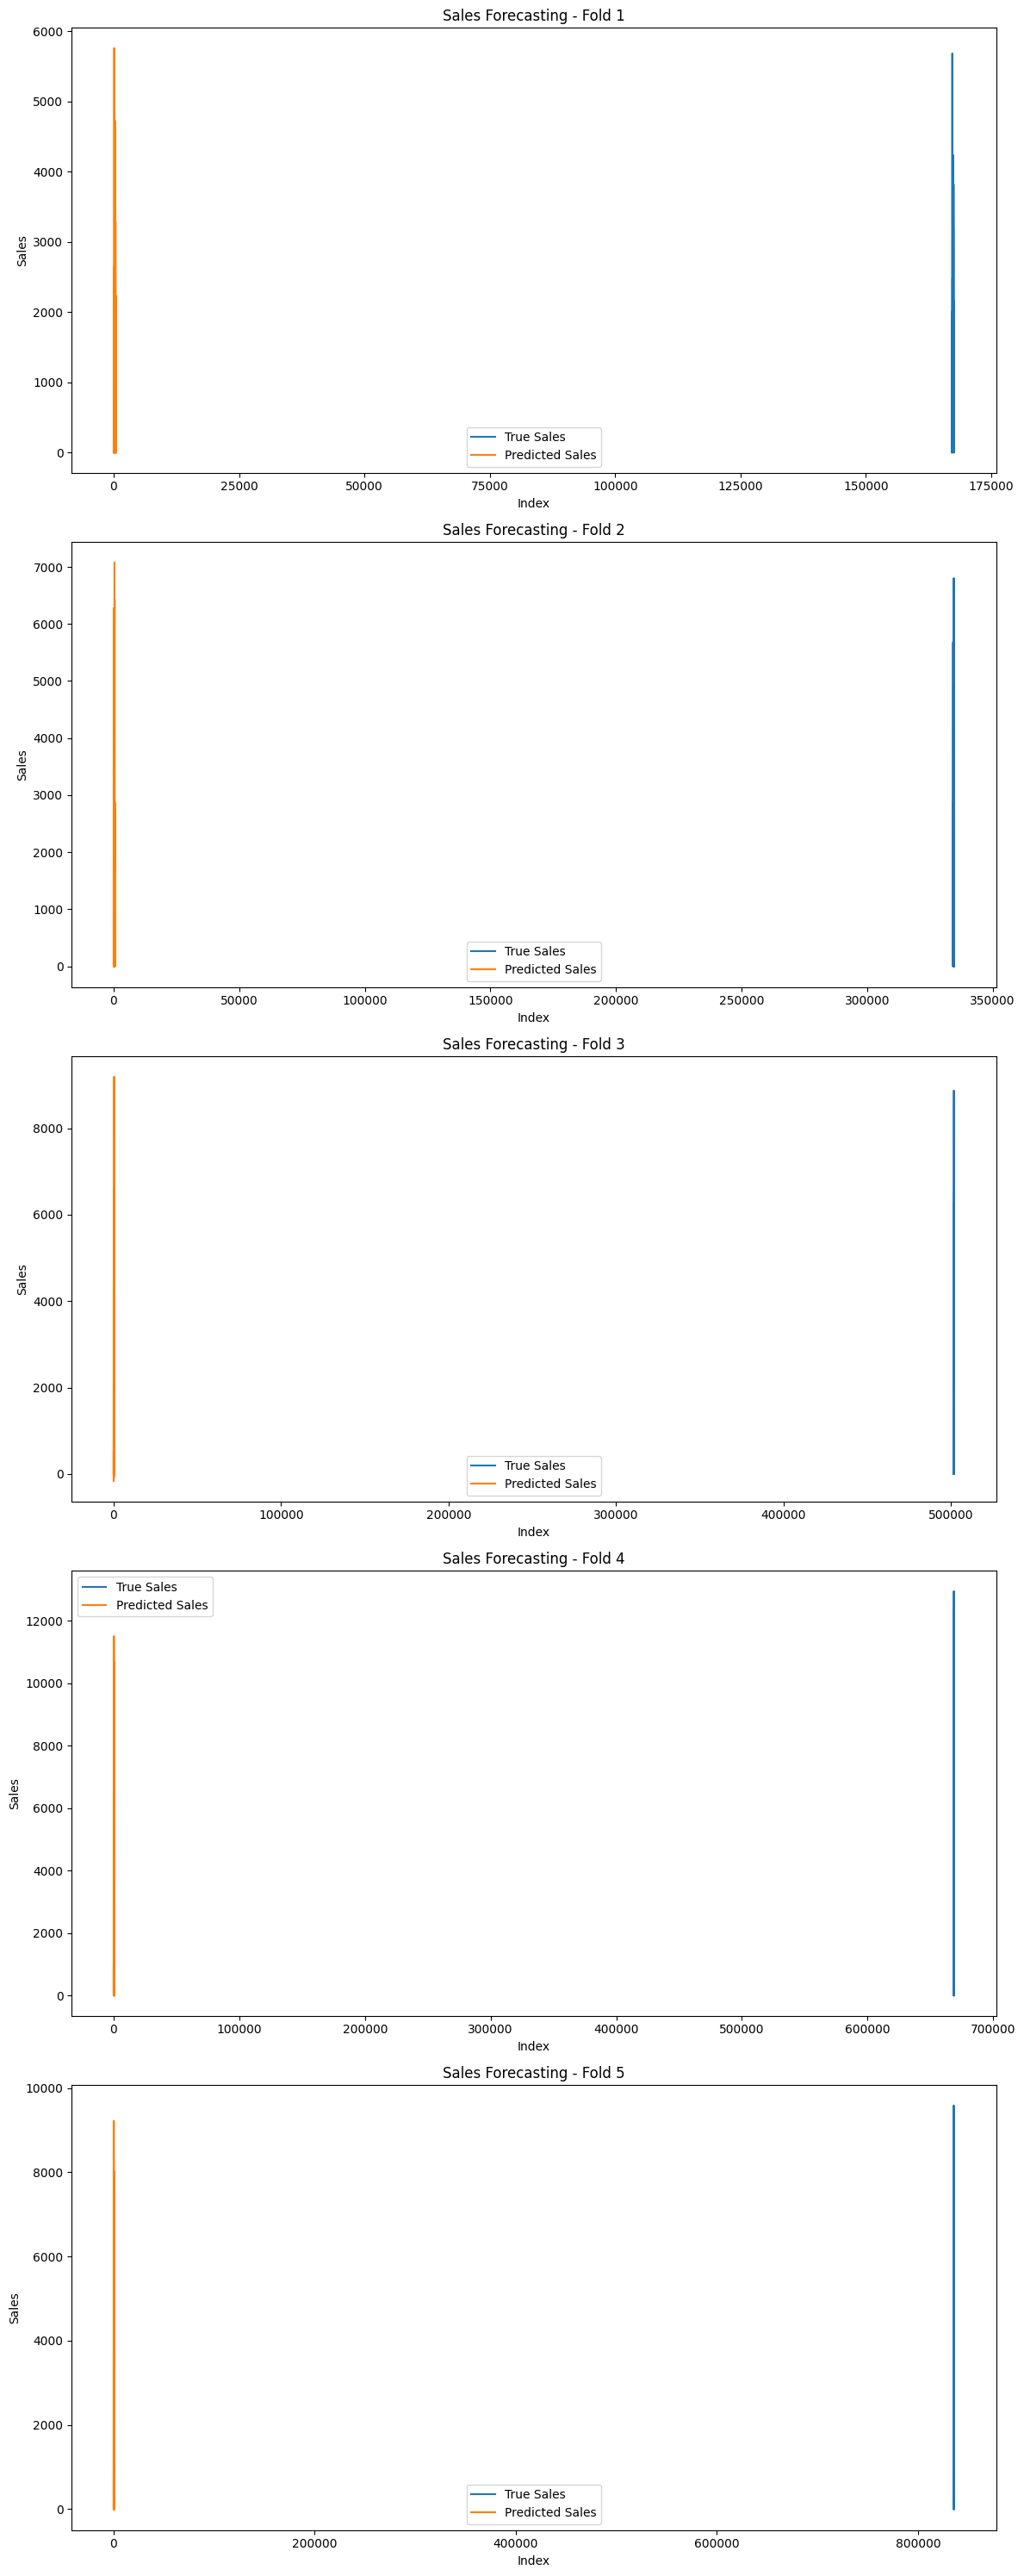

		 Mean MSE 
	 LGBM: 167697.16990110296
		 Mean RMSE 
	 LGBM: 405.3351579626498
		 Mean SMAPE 
	 LGBM: 86.47174301780032
		 Mean R2 
	 LGBM: 0.833836153138648
		 Mean MAE 
	 LGBM: 106.03508738674016
		 Mean MAPE 
	 LGBM: inf
************************************************************


In [135]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have the tscv defined
tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables for plotting
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 6*5))

# Lists to store metrics for each fold
mse_scores = {'lgbm': []}
rmse_scores = {'lgbm': []}
r2_scores = {'lgbm': []}
mae_scores = {'lgbm': []}
mape_scores = {'lgbm': []}
smape_scores = {'lgbm': []}

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_lgbm = lgb.LGBMRegressor(random_state=42, n_estimators=10000, colsample_bytree=0.5)

    object_cols = list(X_train.loc[:, X_train.dtypes == object].columns)

    for c in object_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_lgbm.fit(X_train, y_train, categorical_feature=object_cols)

    y_pred_LGBM = model_lgbm.predict(X_test)

    # Plot true vs predicted sales
    axs[fold_idx].plot(y_test[:500], label='True Sales')
    axs[fold_idx].plot(y_pred_LGBM[:500], label='Predicted Sales')
    axs[fold_idx].legend()
    axs[fold_idx].set_title(f'Sales Forecasting - Fold {fold_idx + 1}')
    axs[fold_idx].set_xlabel('Index')
    axs[fold_idx].set_ylabel('Sales')

    mse_LGBM = mean_squared_error(y_test, y_pred_LGBM)
    rmse_LGBM = np.sqrt(mse_LGBM)
    r2_LGBM = r2_score(y_test, y_pred_LGBM)
    mae_LGBM = mean_absolute_error(y_test, y_pred_LGBM)
    mape_LGBM = np.mean(np.abs((y_test - y_pred_LGBM) / y_test)) * 100
    smape_LGBM = 2 * np.mean(np.abs(y_pred_LGBM - y_test) / (np.abs(y_pred_LGBM) + np.abs(y_test))) * 100

    mse_scores['lgbm'].append(mse_LGBM)
    rmse_scores['lgbm'].append(rmse_LGBM)
    r2_scores['lgbm'].append(r2_LGBM)
    mae_scores['lgbm'].append(mae_LGBM)
    mape_scores['lgbm'].append(mape_LGBM)
    smape_scores['lgbm'].append(smape_LGBM)

    print('*' * 60)

plt.tight_layout()
plt.show()

print(f"\t\t Mean MSE \n\t LGBM: {np.mean(mse_scores['lgbm'])}")
print(f"\t\t Mean RMSE \n\t LGBM: {np.mean(rmse_scores['lgbm'])}")
print(f"\t\t Mean SMAPE \n\t LGBM: {np.mean(smape_scores['lgbm'])}")
print(f"\t\t Mean R2 \n\t LGBM: {np.mean(r2_scores['lgbm'])}")
print(f"\t\t Mean MAE \n\t LGBM: {np.mean(mae_scores['lgbm'])}")
print(f"\t\t Mean MAPE \n\t LGBM: {np.mean(mape_scores['lgbm'])}")
print('*' * 60)


In [136]:
object_cols_cb=['family','store_nbr','family_cluster','store_cluster']

In [137]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = cb.CatBoostRegressor(random_seed=42)
    
    #object_cols = list(X_train.loc[:,X_train.dtypes==np.object].columns)
    
    for c in object_cols_cb:
        X_train[c] = X_train[c].astype('category')
        X_test[c] = X_test[c].astype('category')

    model_cb.fit(X_train, y_train, cat_features=object_cols_cb,
                 #eval_set=[(X_test, y_test)], 
                 #early_stopping_rounds=50
                )

    y_pred_cb = model_cb.predict(X_test)

    models['catboost_model'].append(model_cb)

    mse_cb, rmse_cb, r2_cb, mae_cb, mape_cb, smape_cb = metrics_regression(
        y_test, y_pred_cb)

    mse_scores['catboost_model'].append(mse_cb)
    rmse_scores['catboost_model'].append(rmse_cb)
    r2_scores['catboost_model'].append(r2_cb)
    mae_scores['catboost_model'].append(mae_cb)
    mape_scores['catboost_model'].append(mape_cb)
    smape_scores['catboost_model'].append(smape_cb)
    
    #print(f"\t Score for catboost_model: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t catboost_model: {np.mean(mse_scores['catboost_model'])}")
print(f"\t\t Mean RMSE \n\t catboost_model: {np.mean(rmse_scores['catboost_model'])}")
print(f"\t\t Mean R2 \n\t catboost_model: {np.mean(r2_scores['catboost_model'])}")
print(f"\t\t Mean MAE \n\t catboost_model: {np.mean(mae_scores['catboost_model'])}")
print(f"\t\t Mean MAPE \n\t catboost_model: {np.mean(mape_scores['catboost_model'])}")
print(f"\t\t Mean SMAPE \n\t catboost_model: {np.mean(smape_scores['catboost_model'])}")
print('*'*60)

Fold 1
Learning rate set to 0.091921
0:	learn: 613.3285367	total: 209ms	remaining: 3m 28s
1:	learn: 567.4041938	total: 342ms	remaining: 2m 50s
2:	learn: 525.3645626	total: 469ms	remaining: 2m 35s
3:	learn: 486.3464833	total: 595ms	remaining: 2m 28s
4:	learn: 450.6769322	total: 712ms	remaining: 2m 21s
5:	learn: 418.7732583	total: 841ms	remaining: 2m 19s
6:	learn: 389.7634958	total: 964ms	remaining: 2m 16s
7:	learn: 364.2512514	total: 1.08s	remaining: 2m 14s
8:	learn: 341.2169906	total: 1.21s	remaining: 2m 12s
9:	learn: 320.7891505	total: 1.33s	remaining: 2m 12s
10:	learn: 302.3434256	total: 1.44s	remaining: 2m 9s
11:	learn: 285.6734121	total: 1.57s	remaining: 2m 9s
12:	learn: 270.8244744	total: 1.69s	remaining: 2m 8s
13:	learn: 257.9423571	total: 1.79s	remaining: 2m 6s
14:	learn: 246.8401183	total: 1.9s	remaining: 2m 4s
15:	learn: 237.0397395	total: 2.02s	remaining: 2m 4s
16:	learn: 228.0884749	total: 2.15s	remaining: 2m 4s
17:	learn: 220.4985279	total: 2.28s	remaining: 2m 4s
18:	learn:

KeyError: 'catboost_model'

In [138]:
#X.dtypes [X.dtypes != 'float64']
object_cols_lr=['family','store_nbr','family_cluster','store_cluster']

for c in object_cols_lr:
    X[c] = X[c].astype('category')
    
category_cols_lr=['family','store_nbr','family_cluster','store_cluster']
numeric_cols = list(X.select_dtypes(exclude='category').columns)

cols_for_oh = [list(X.columns).index(col) for col in category_cols_lr]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_cols]

t = [('OneHotEncoder', OneHotEncoder(), cols_for_oh),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)
    ]

col_transform = ColumnTransformer(transformers=t)

In [139]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_LR = Pipeline([("column_transformer",col_transform),
                        ("linear_regression", LinearRegression())])

    pipe_LR.fit(X_train, y_train)

    y_pred_LR = pipe_LR.predict(X_test)

    models['linear_regression'].append(pipe_LR)
    
    mse_lr,rmse_lr,r2_lr,mae_lr,mape_lr,smape_lr = metrics_regression(y_test, y_pred_LR)

    mse_scores['linear_regression'].append(mse_lr)
    rmse_scores['linear_regression'].append(rmse_lr)
    r2_scores['linear_regression'].append(r2_lr)
    mae_scores['linear_regression'].append(mae_lr)
    mape_scores['linear_regression'].append(mape_lr)
    smape_scores['linear_regression'].append(smape_lr)
    #rmsle_scores['linear_regression'].append(rmsle_lr)
    
    #print(f"\t Score for linear regression: {mse_scores,rmse_scores,r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t LR: {np.mean(mse_scores['linear_regression'])}")
print(f"\t\t Mean RMSE \n\t LR: {np.mean(rmse_scores['linear_regression'])}")
print(f"\t\t Mean R2 \n\t LR: {np.mean(r2_scores['linear_regression'])}")
print(f"\t\t Mean MAE \n\t LR: {np.mean(mae_scores['linear_regression'])}")
print(f"\t\t Mean MAPE \n\t LR: {np.mean(mape_scores['linear_regression'])}")
print(f"\t\t Mean SMAPE \n\t LR: {np.mean(smape_scores['linear_regression'])}")
print('*'*60)

Fold 1


KeyError: 'linear_regression'

In [140]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_DTR = Pipeline([("column_transformer",col_transform),
                         ("decision_tree", 
                          DecisionTreeRegressor())])

    pipe_DTR.fit(X_train, y_train)

    y_pred_DTR = pipe_DTR.predict(X_test)

    models['decision_tree'].append(pipe_DTR)
    
    mse_dtr,rmse_dtr,r2_dtr,mae_dtr,mape_dtr,smape_dtr = metrics_regression(y_test, y_pred_DTR)

    mse_scores['decision_tree'].append(mse_dtr)
    rmse_scores['decision_tree'].append(rmse_dtr)
    r2_scores['decision_tree'].append(r2_dtr)
    mae_scores['decision_tree'].append(mae_dtr)
    mape_scores['decision_tree'].append(mape_dtr)
    smape_scores['decision_tree'].append(smape_dtr)
    
    #print(f"\t Score for decision_tree: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t DTR: {np.mean(mse_scores['decision_tree'])}")
print(f"\t\t Mean RMSE \n\t DTR: {np.mean(rmse_scores['decision_tree'])}")
print(f"\t\t Mean R2 \n\t DTR: {np.mean(r2_scores['decision_tree'])}")
print(f"\t\t Mean MAE \n\t DTR: {np.mean(mae_scores['decision_tree'])}")
print(f"\t\t Mean MAPE \n\t DTR: {np.mean(mape_scores['decision_tree'])}")
print(f"\t\t Mean SMAPE \n\t DTR: {np.mean(smape_scores['decision_tree'])}")
print('*'*60)

Fold 1


KeyError: 'decision_tree'

In [141]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_lasso = Pipeline([("column_transformer",col_transform),
                           ("Lasso", Lasso())])

    pipe_lasso.fit(X_train, y_train)

    y_pred_lasso = pipe_lasso.predict(X_test)

    models['Lasso'].append(pipe_lasso)
    
    mse_lasso,rmse_lasso,r2_lasso,mae_lasso,mape_lasso,smape_lasso = metrics_regression(
        y_test, y_pred_lasso)

    mse_scores['Lasso'].append(mse_lasso)
    rmse_scores['Lasso'].append(rmse_lasso)
    r2_scores['Lasso'].append(r2_lasso)
    mae_scores['Lasso'].append(mae_lasso)
    mape_scores['Lasso'].append(mape_lasso)
    smape_scores['Lasso'].append(smape_lasso)
    
    #print(f"\t Score for Lasso: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Lasso: {np.mean(mse_scores['Lasso'])}")
print(f"\t\t Mean RMSE \n\t Lasso: {np.mean(rmse_scores['Lasso'])}")
print(f"\t\t Mean R2 \n\t Lasso: {np.mean(r2_scores['Lasso'])}")
print(f"\t\t Mean MAE \n\t Lasso: {np.mean(mae_scores['Lasso'])}")
print(f"\t\t Mean MAPE \n\t Lasso: {np.mean(mape_scores['Lasso'])}")
print(f"\t\t Mean SMAPE \n\t Lasso: {np.mean(smape_scores['Lasso'])}")
print('*'*60)

Fold 1


KeyError: 'Lasso'

In [142]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_ridge = Pipeline([("column_transformer",col_transform),
                           ("Ridge", Ridge())])

    pipe_ridge.fit(X_train, y_train)

    y_pred_ridge = pipe_ridge.predict(X_test)

    models['Ridge'].append(pipe_ridge)
    
    mse_ridge, rmse_ridge, r2_ridge, mae_ridge, mape_ridge, smape_ridge = metrics_regression(
        y_test, y_pred_ridge)

    mse_scores['Ridge'].append(mse_ridge)
    rmse_scores['Ridge'].append(rmse_ridge)
    r2_scores['Ridge'].append(r2_ridge)
    mae_scores['Ridge'].append(mae_ridge)
    mape_scores['Ridge'].append(mape_ridge)
    smape_scores['Ridge'].append(smape_ridge)
    
    #print(f"\t Score for Ridge: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t Ridge: {np.mean(mse_scores['Ridge'])}")
print(f"\t\t Mean RMSE \n\t Ridge: {np.mean(rmse_scores['Ridge'])}")
print(f"\t\t Mean R2 \n\t Ridge: {np.mean(r2_scores['Ridge'])}")
print(f"\t\t Mean MAE \n\t Ridge: {np.mean(mae_scores['Ridge'])}")
print(f"\t\t Mean MAPE \n\t Ridge: {np.mean(mape_scores['Ridge'])}")
print(f"\t\t Mean SMAPE \n\t Ridge: {np.mean(smape_scores['Ridge'])}")
print('*'*60)

Fold 1


KeyError: 'Ridge'

In [143]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe_en = Pipeline([("column_transformer",col_transform),
                        ("elastic_net", ElasticNet())])

    pipe_en.fit(X_train, y_train)

    y_pred_en = pipe_en.predict(X_test)

    models['elastic_net'].append(pipe_en)
    
    mse_en, rmse_en, r2_en, mae_en, mape_en, smape_en = metrics_regression(
        y_test, y_pred_en)

    mse_scores['elastic_net'].append(mse_en)
    rmse_scores['elastic_net'].append(rmse_en)
    r2_scores['elastic_net'].append(r2_en)
    mae_scores['elastic_net'].append(mae_en)
    mape_scores['elastic_net'].append(mape_en)
    smape_scores['elastic_net'].append(smape_en)
    
    #print(f"\t Score for elastic_net: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t elastic_net: {np.mean(mse_scores['elastic_net'])}")
print(f"\t\t Mean RMSE \n\t elastic_net: {np.mean(rmse_scores['elastic_net'])}")
print(f"\t\t Mean R2 \n\t elastic_net: {np.mean(r2_scores['elastic_net'])}")
print(f"\t\t Mean MAE \n\t elastic_net: {np.mean(mae_scores['elastic_net'])}")
print(f"\t\t Mean MAPE \n\t elastic_net: {np.mean(mape_scores['elastic_net'])}")
print(f"\t\t Mean SMAPE \n\t elastic_net: {np.mean(smape_scores['elastic_net'])}")
print('*'*60)

Fold 1


KeyError: 'elastic_net'

In [144]:
%%time

for fold_idx, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold_idx + 1}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipe_xgb = Pipeline([("column_transformer",col_transform),
                         ("xgbr", XGBRegressor())])

    pipe_xgb.fit(X_train, y_train)

    y_pred_xgb = pipe_xgb.predict(X_test)

    models['xgbr'].append(pipe_xgb)

    mse_xgb, rmse_xgb, r2_xgb, mae_xgb, mape_xgb, smape_xgb = metrics_regression(
        y_test, y_pred_xgb)

    mse_scores['xgbr'].append(mse_xgb)
    rmse_scores['xgbr'].append(rmse_xgb)
    r2_scores['xgbr'].append(r2_xgb)
    mae_scores['xgbr'].append(mae_xgb)
    mape_scores['xgbr'].append(mape_xgb)
    smape_scores['xgbr'].append(smape_xgb)
    
    #print(f"\t Score for xgbr: {mse_scores,rmse_scores, r2_scores,mae_scores,mape_scores,smape_scores}")
    print('*'*60)

print(f"\t\t Mean MSE \n\t xgbr: {np.mean(mse_scores['xgbr'])}")
print(f"\t\t Mean RMSE \n\t xgbr: {np.mean(rmse_scores['xgbr'])}")
print(f"\t\t Mean R2 \n\t xgbr: {np.mean(r2_scores['xgbr'])}")
print(f"\t\t Mean MAE \n\t xgbr: {np.mean(mae_scores['xgbr'])}")
print(f"\t\t Mean MAPE \n\t xgbr: {np.mean(mape_scores['xgbr'])}")
print(f"\t\t Mean SMAPE \n\t xgbr: {np.mean(smape_scores['xgbr'])}")
print('*'*60)

Fold 1


KeyError: 'xgbr'

In [145]:
# !the calculation is made, but does not participate in the selection of the optimal model due to instability
del mse_scores['decision_tree']
del rmse_scores['decision_tree']
del mae_scores['decision_tree']
del mape_scores['decision_tree']
del smape_scores['decision_tree']

KeyError: 'decision_tree'

In [ ]:
df_mse = pd.DataFrame.from_dict(data=mse_scores, orient='index', columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mse['mean'] = df_mse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mse

In [ ]:
df_mse['mean'].plot.barh()

In [ ]:
df_rmse = pd.DataFrame.from_dict(data=rmse_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_rmse['mean'] = df_rmse[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_rmse

In [ ]:
df_rmse['mean'].plot.barh()

In [ ]:
df_mae = pd.DataFrame.from_dict(data=mae_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mae['mean'] = df_mae[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mae

In [ ]:
df_mae['mean'].plot.barh()

In [ ]:
df_mape = pd.DataFrame.from_dict(data=mape_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_mape['mean'] = df_mape[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_mape

In [ ]:
df_mape['mean'].plot.barh()

In [ ]:
df_smape = pd.DataFrame.from_dict(data=smape_scores, orient='index',columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
df_smape['mean'] = df_smape[['fold_1','fold_2','fold_3','fold_4', 'fold_5']].mean(axis= 1)
df_smape

In [ ]:
df_smape['mean'].plot.barh()